In [130]:
! pip install uv
! uv pip install numpy pandas wfdb matplotlib ecgmentations pytorch_metric_learning scikit-learn --quiet
! uv pip install --upgrade --pre torch torchvision --index-url https://download.pytorch.org/whl/nightly/cu130

Using Python 3.12.3 environment at: /home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv
⠙ Resolving dependencies...                                                     Using Python 3.12.3 environment at: /home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv
⠸ torch==2.10.0.dev20251114+cu130                                               

In [1]:
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()

/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


(True, True)

In [2]:
from src import CheckpointManager
from src import train
from src import ECGContrastiveTrainDataset, ECGDataset, DualAugmenter
from pytorch_metric_learning.losses import NTXentLoss

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 31.21M parameters


# Loading the dataset

## New Dataset

In [3]:
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

superclass_cols_defaults = ["NORM", "MI", "STTC", "HYP", "CD"]


def load_signal_cube(signal_csv: Union[str, Path],
                     expected_channels: Optional[List[str]] = None,
                     expected_len: Optional[int] = None) -> Tuple[np.ndarray, Dict[int, int], List[str], int]:
    df = pd.read_csv(signal_csv)
    if "ecg_id" not in df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {signal_csv}")

    df = df.sort_values("ecg_id", kind="mergesort").reset_index(drop=True)
    channel_cols = [col for col in df.columns if col != "ecg_id"]
    if expected_channels is not None and channel_cols != expected_channels:
        raise ValueError("Channel layout differs across splits")

    counts = df.groupby("ecg_id", sort=False).size()
    lengths = counts.unique()
    if len(lengths) != 1:
        raise ValueError("Signals have inconsistent lengths; expected a fixed 1000-sample window")
    signal_len = int(lengths[0])
    if expected_len is not None and signal_len != expected_len:
        raise ValueError("Signal length differs across splits")

    signal_cube = df[channel_cols].to_numpy(dtype=np.float32).reshape(-1, signal_len, len(channel_cols))
    ecg_ids = counts.index.to_numpy()
    id_lookup = {int(eid): idx for idx, eid in enumerate(ecg_ids)}
    return signal_cube, id_lookup, channel_cols, signal_len


def extract_single_subclass(meta_csv: Union[str, Path],
                            subclass_cols: Optional[List[str]] = None,
                            superclass_cols: Optional[List[str]] = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray, int, List[str], List[str]]:
    meta_df = pd.read_csv(meta_csv)
    if "ecg_id" not in meta_df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {meta_csv}")

    if subclass_cols is None:
        subclass_cols = [col for col in meta_df.columns if col.startswith("sub_")]
    missing_sub = [col for col in subclass_cols if col not in meta_df.columns]
    if missing_sub:
        raise ValueError(f"Columns {missing_sub} are missing from {meta_csv}")

    target_superclass_cols = superclass_cols or superclass_cols_defaults
    missing_super = [col for col in target_superclass_cols if col not in meta_df.columns]
    if missing_super:
        raise ValueError(f"Columns {missing_super} are missing from {meta_csv}")

    subset = meta_df[["ecg_id", *subclass_cols, *target_superclass_cols]].dropna(subset=["ecg_id"]).copy()
    subset["ecg_id"] = subset["ecg_id"].astype(int)
    subclass_values = subset[subclass_cols].fillna(0).astype(int).to_numpy()

    label_counts = (subclass_values > 0).sum(axis=1)
    single_mask = label_counts == 1
    dropped = int((~single_mask).sum())

    filtered_subset = subset[single_mask]
    filtered_ids = filtered_subset["ecg_id"].to_numpy()
    filtered_labels = np.array(subclass_cols)[subclass_values[single_mask].argmax(axis=1)]
    superclass_values = filtered_subset[target_superclass_cols].fillna(0).astype(int).to_numpy()

    return filtered_ids, filtered_labels, superclass_values, dropped, subclass_cols, target_superclass_cols


data_root = Path("/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw")
split_paths = {
    "train": {
        "signal": data_root / "train_signal.csv",
        "meta": data_root / "train_meta.csv",
    },
    "val": {
        "signal": data_root / "valid_signal.csv",
        "meta": data_root / "valid_meta.csv",
    },
    "test": {
        "signal": data_root / "test_signal.csv",
        "meta": data_root / "test_meta.csv",
    },
}

csv_splits: Dict[str, Dict[str, np.ndarray]] = {}
expected_channels: Optional[List[str]] = None
expected_len: Optional[int] = None
subclass_cols: Optional[List[str]] = None
superclass_cols: Optional[List[str]] = None

for split_name, paths in split_paths.items():
    signals, lookup, channel_cols, signal_len = load_signal_cube(
        paths["signal"], expected_channels=expected_channels, expected_len=expected_len
    )
    if expected_channels is None:
        expected_channels = channel_cols
    if expected_len is None:
        expected_len = signal_len

    ids, labels, superclass_values, dropped, subclass_cols, detected_superclasses = extract_single_subclass(
        paths["meta"], subclass_cols=subclass_cols, superclass_cols=superclass_cols
    )

    if superclass_cols is None:
        superclass_cols = detected_superclasses

    missing = [eid for eid in ids if eid not in lookup]
    if missing:
        raise ValueError(f"{split_name} meta rows missing signal data: {missing[:3]} ...")

    ordered_indices = [lookup[int(eid)] for eid in ids]
    csv_splits[split_name] = {
        "X": signals[ordered_indices],
        "labels": labels,
        "ecg_ids": ids,
        "dropped_multi_label": dropped,
        "superclasses": superclass_values,
    }

label_encoder = LabelEncoder()
label_encoder.fit(
    np.concatenate([csv_splits["train"]["labels"], csv_splits["val"]["labels"], csv_splits["test"]["labels"]])
)

for split_data in csv_splits.values():
    split_data["y_int"] = label_encoder.transform(split_data["labels"])

label_to_idx = {label: int(idx) for idx, label in enumerate(label_encoder.classes_)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

X_train_filtered = csv_splits["train"]["X"]
y_train_int = csv_splits["train"]["y_int"]
X_val_filtered = csv_splits["val"]["X"]
y_val_int = csv_splits["val"]["y_int"]
X_test_filtered = csv_splits["test"]["X"]
y_test_int = csv_splits["test"]["y_int"]

Y_train_superclasses = csv_splits["train"]["superclasses"]
Y_val_superclasses = csv_splits["val"]["superclasses"]
Y_test_superclasses = csv_splits["test"]["superclasses"]

print("Loaded CSV-based splits (after filtering to single subclass per record):")
for split_name in ["train", "val", "test"]:
    split = csv_splits[split_name]
    print(
        f"  {split_name.title():>5}: X={split['X'].shape}, unique subclasses={np.unique(split['labels']).size}, "
        f"dropped multi-label rows={split['dropped_multi_label']}, superclasses shape={split['superclasses'].shape}"
    )
print(f"Subclass count: {len(label_encoder.classes_)}")
print(f"Superclass columns: {superclass_cols}")

Loaded CSV-based splits (after filtering to single subclass per record):
  Train: X=(12123, 1000, 12), unique subclasses=22, dropped multi-label rows=5318, superclasses shape=(12123, 5)
    Val: X=(1555, 1000, 12), unique subclasses=20, dropped multi-label rows=638, superclasses shape=(1555, 5)
   Test: X=(1561, 1000, 12), unique subclasses=21, dropped multi-label rows=642, superclasses shape=(1561, 5)
Subclass count: 23
Superclass columns: ['NORM', 'MI', 'STTC', 'HYP', 'CD']


### Prepare CSV-based train/val/test splits
Run this section when you want to drive the rest of the notebook with the reformatted CSV exports (skipping the older PTB-XL reader below).

## Older Dataset

In [ ]:
import ast

import numpy as np
import pandas as pd
import wfdb


def load_raw_data(df, sampling_rate, path):
    if sampling_rate == 100:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_lr[:1500]]
    else:
        data = [wfdb.rdsamp(path + "/" + f) for f in df.filename_hr[:1500]]
    data = np.array([signal for signal, meta in data])
    return data


path = "/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/data/raw/ptb-xl-a-large-publicly-available-electrocardiography-dataset-1.0.1"
sampling_rate = 100

# load and convert annotation data
Y = pd.read_csv(path + "/ptbxl_database.csv", index_col="ecg_id")[:1500]
Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

# Load raw signal data
X = load_raw_data(Y, sampling_rate, path)

# Load scp_statements.csv for diagnostic aggregation
agg_df = pd.read_csv(path + "/scp_statements.csv", index_col=0)
agg_df = agg_df[agg_df.diagnostic == 1]


def aggregate_diagnostic(y_dic):
    tmp = []
    for key in y_dic.keys():
        if key in agg_df.index:
            tmp.append(agg_df.loc[key].diagnostic_class)
    return list(set(tmp))


# Apply diagnostic superclass
Y["diagnostic_superclass"] = Y.scp_codes.apply(aggregate_diagnostic)




# Split data into train, validation, and test
test_fold = 10
val_fold = 9
# Train
X_train = X[np.where((Y.strat_fold != test_fold) & (Y.strat_fold != val_fold))]
y_train = Y[(Y.strat_fold != test_fold) & (Y.strat_fold != val_fold)].diagnostic_superclass
# Validation
X_val = X[np.where(Y.strat_fold == val_fold)]
y_val = Y[Y.strat_fold == val_fold].diagnostic_superclass
# Test
X_test = X[np.where(Y.strat_fold == test_fold)]
y_test = Y[Y.strat_fold == test_fold].diagnostic_superclass


In [ ]:
X_val.shape, X_test.shape, X_train.shape

((188, 1000, 12), (194, 1000, 12), (1118, 1000, 12))

In [ ]:
# Check the data structure - see examples of diagnostic_superclass
print("Sample y_train values:")
print(y_train.head(10))
print("\nValue counts:")
print(y_train.apply(lambda x: len(x) if isinstance(x, list) else 0).value_counts())
print("\nSample with multiple labels:")
multi_label_examples = y_train[y_train.apply(lambda x: isinstance(x, list) and len(x) > 1)]
print(f"Found {len(multi_label_examples)} samples with multiple labels")
if len(multi_label_examples) > 0:
    print(multi_label_examples.head())

Sample y_train values:
ecg_id
1     [NORM]
2     [NORM]
3     [NORM]
4     [NORM]
5     [NORM]
6     [NORM]
7     [NORM]
11    [NORM]
12    [NORM]
13    [NORM]
Name: diagnostic_superclass, dtype: object

Value counts:
diagnostic_superclass
1    879
2    186
3     34
4     14
0      5
Name: count, dtype: int64

Sample with multiple labels:
Found 234 samples with multiple labels
ecg_id
45      [HYP, CD]
50       [MI, CD]
77       [MI, CD]
87     [STTC, CD]
102    [STTC, CD]
Name: diagnostic_superclass, dtype: object


In [ ]:
# Get all unique diagnostic classes
all_labels = []
for labels_list in pd.concat([y_train, y_val, y_test]):
    if isinstance(labels_list, list):
        all_labels.extend(labels_list)

unique_diagnostic_classes = sorted(set(all_labels))
print(f"Unique diagnostic classes: {unique_diagnostic_classes}")
print(f"Total number of classes: {len(unique_diagnostic_classes)}")

Unique diagnostic classes: ['CD', 'HYP', 'MI', 'NORM', 'STTC']
Total number of classes: 5


In [ ]:
# Filter out rows with multiple labels (keep only single-label samples)
def filter_single_label(y_series, X_array):
    """Filter to keep only samples with exactly one label"""
    single_label_mask = y_series.apply(lambda x: isinstance(x, list) and len(x) == 1)
    y_filtered = y_series[single_label_mask].copy()
    X_filtered = X_array[single_label_mask.values]
    return X_filtered, y_filtered

# Apply filtering to train, val, and test sets
X_train_filtered, y_train_filtered = filter_single_label(y_train, X_train)
X_val_filtered, y_val_filtered = filter_single_label(y_val, X_val)
X_test_filtered, y_test_filtered = filter_single_label(y_test, X_test)

print("Original sizes:")
print(f"Train: {len(y_train)}, Val: {len(y_val)}, Test: {len(y_test)}")
print("\nFiltered sizes (single label only):")
print(f"Train: {len(y_train_filtered)}, Val: {len(y_val_filtered)}, Test: {len(y_test_filtered)}")
print(f"\nRemoved {len(y_train) - len(y_train_filtered)} multi-label samples from train")
print(f"Removed {len(y_val) - len(y_val_filtered)} multi-label samples from val")
print(f"Removed {len(y_test) - len(y_test_filtered)} multi-label samples from test")

Original sizes:
Train: 1118, Val: 188, Test: 194

Filtered sizes (single label only):
Train: 879, Val: 133, Test: 153

Removed 239 multi-label samples from train
Removed 55 multi-label samples from val
Removed 41 multi-label samples from test


In [ ]:
# Create label mapping from diagnostic class strings to integers
label_to_idx = {label: idx for idx, label in enumerate(unique_diagnostic_classes)}
idx_to_label = {idx: label for label, idx in label_to_idx.items()}

print("Label mapping:")
for label, idx in label_to_idx.items():
    print(f"  {label} -> {idx}")

# Convert labels from list of strings to integers
def map_labels_to_int(y_series, label_mapping):
    """Convert single-element label lists to integer labels"""
    return y_series.apply(lambda x: label_mapping[x[0]])

y_train_int = map_labels_to_int(y_train_filtered, label_to_idx)
y_val_int = map_labels_to_int(y_val_filtered, label_to_idx)
y_test_int = map_labels_to_int(y_test_filtered, label_to_idx)

print("\nLabel distribution in train set:")
print(y_train_int.value_counts().sort_index())
print("\nLabel distribution in val set:")
print(y_val_int.value_counts().sort_index())
print("\nLabel distribution in test set:")
print(y_test_int.value_counts().sort_index())

Label mapping:
  CD -> 0
  HYP -> 1
  MI -> 2
  NORM -> 3
  STTC -> 4

Label distribution in train set:
diagnostic_superclass
0     84
1     29
2     68
3    589
4    109
Name: count, dtype: int64

Label distribution in val set:
diagnostic_superclass
0    11
1     3
2    12
3    86
4    21
Name: count, dtype: int64

Label distribution in test set:
diagnostic_superclass
0    15
1     3
2    15
3    99
4    21
Name: count, dtype: int64


# Data Augmenter and Dataset Classes

In [4]:
# Create classification datasets
# The training dataset will compute the normalization stats
# Val and test will reuse those stats for consistency

train_dataset_classification = ECGDataset(
    X=X_train_filtered,
    y=y_train_int
)

# Reuse training stats for validation and test
val_dataset_classification = ECGDataset(
    X=X_val_filtered,
    y=y_val_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

test_dataset_classification = ECGDataset(
    X=X_test_filtered,
    y=y_test_int,
    channel_means=train_dataset_classification.channel_means,
    channel_stds=train_dataset_classification.channel_stds
)

print(f"Train dataset size: {len(train_dataset_classification)}")
print(f"Validation dataset size: {len(val_dataset_classification)}")
print(f"Test dataset size: {len(test_dataset_classification)}")
print(f"Number of classes: {test_dataset_classification.num_classes}")

print(f"\nNormalization stats computed from training set:")
print(f"  Channel means shape: {train_dataset_classification.channel_means.shape}")
print(f"  Channel stds shape: {train_dataset_classification.channel_stds.shape}")
print(f"  Std range: [{train_dataset_classification.channel_stds.min():.6f}, {train_dataset_classification.channel_stds.max():.6f}]")

# Test a sample
sample_signal, sample_label = val_dataset_classification[-1]
print(f"\nSample signal shape: {sample_signal.shape}")
print(f"Sample label (numerical): {sample_label}")

Train dataset size: 12123
Validation dataset size: 1555
Test dataset size: 1561
Number of classes: 23

Normalization stats computed from training set:
  Channel means shape: (12,)
  Channel stds shape: (12,)
  Std range: [0.132004, 0.313382]

Sample signal shape: torch.Size([1000, 12])
Sample label (numerical): 14


In [5]:
# Create DataLoaders for classification training
from torch.utils.data import DataLoader

batch_size = 64

train_loader_classification = DataLoader(
    train_dataset_classification, 
    batch_size=batch_size, 
    shuffle=True,
    num_workers=4,
    pin_memory=True
)

val_loader_classification = DataLoader(
    val_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

test_loader_classification = DataLoader(
    test_dataset_classification, 
    batch_size=batch_size, 
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Created DataLoaders for classification:")
print(f"  Train: {len(train_dataset_classification)} samples, {len(train_loader_classification)} batches")
print(f"  Val:   {len(val_dataset_classification)} samples, {len(val_loader_classification)} batches")
print(f"  Test:  {len(test_dataset_classification)} samples, {len(test_loader_classification)} batches")

# Verify the data format
for signals, labels in train_loader_classification:
    print(f"\nBatch shapes:")
    print(f"  Signals: {signals.shape}")  # Should be (batch_size, time_steps, num_channels)
    print(f"  Labels: {labels.shape}, dtype: {labels.dtype}")  # Should be (batch_size,) with int dtype
    print(f"  Label range: [{labels.min()}, {labels.max()}]")
    break

Created DataLoaders for classification:
  Train: 12123 samples, 190 batches
  Val:   1555 samples, 25 batches
  Test:  1561 samples, 25 batches

Batch shapes:
  Signals: torch.Size([64, 1000, 12])
  Labels: torch.Size([64]), dtype: torch.int64
  Label range: [0, 20]


# Custom Augmentations.

In [6]:
import ecgmentations as E
from scipy.spatial.distance import cosine
import torch

# Define augmentation pool
augmentation_pool = [
    E.TimeShift(p=1.0),
    E.GaussNoise(p=1.0),
    E.PowerlineNoise(p=1.0, ecg_frequency=60),
    E.RespirationNoise(p=1.0),
    E.AmplitudeScale(p=1.0),
    E.TimeCutout(p=1.0),
]

# Create dual augmenter with both min and max similarity thresholds
dual_augmenter = DualAugmenter(
    augmentation_pool=augmentation_pool,
    min_similarity=0.35,   # Augmentations must be at least 35% similar
    max_similarity=0.80,  # But not more than 80% similar
    max_retries=5,
)

# Create contrastive datasets
# Training dataset computes normalization stats
train_dataset = ECGContrastiveTrainDataset(
    X=X_train_filtered, 
    y=y_train_int, 
    dual_augmenter=dual_augmenter
)

# Val and test reuse training stats
val_dataset = ECGContrastiveTrainDataset(
    X=X_val_filtered, 
    y=y_val_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

test_dataset = ECGContrastiveTrainDataset(
    X=X_test_filtered, 
    y=y_test_int, 
    dual_augmenter=dual_augmenter,
    channel_means=train_dataset.channel_means,
    channel_stds=train_dataset.channel_stds
)

print(f"✓ Created contrastive datasets")
print(f"  Train: {len(train_dataset)} samples")
print(f"  Val: {len(val_dataset)} samples")
print(f"  Test: {len(test_dataset)} samples")

print(f"\n✓ Normalization stats from training set:")
print(f"  Channel means: {train_dataset.channel_means}")
print(f"  Channel stds: {train_dataset.channel_stds}")

# Test augmentation on a sample from the dataset
aug1, aug2 = train_dataset[0]
print(f"\n✓ Sample augmentation test:")
print(f"  Aug1 shape: {aug1.shape}")
print(f"  Aug2 shape: {aug2.shape}")
print(f"  Are they identical? {torch.equal(aug1, aug2)}")

# Calculate similarity between augmented views
similarity = 1 - cosine(aug1.numpy().flatten(), aug2.numpy().flatten())
print(f"  Cosine similarity: {similarity:.4f}")
print(f"  Within range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
      f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

✓ Created contrastive datasets
  Train: 12123 samples
  Val: 1555 samples
  Test: 1561 samples

✓ Normalization stats from training set:
  Channel means: [-0.00232877 -0.00169563  0.00063265  0.00200246 -0.00141647 -0.00049853
  0.00037527 -0.00100671 -0.00171681 -0.00142823 -0.00060924 -0.00289744]
  Channel stds: [0.16334234 0.15602323 0.1546288  0.13977736 0.13857803 0.13200407
 0.21584226 0.31338233 0.3040858  0.27779695 0.25841653 0.28678465]

✓ Sample augmentation test:
  Aug1 shape: torch.Size([1000, 12])
  Aug2 shape: torch.Size([1000, 12])
  Are they identical? False
  Cosine similarity: 0.8092
  Within range [0.35, 0.8]? False


Visualize the signals?

# Visualization

## Visualization: Raw Data

Let's visualize some raw ECG signals before any preprocessing to understand the data structure.

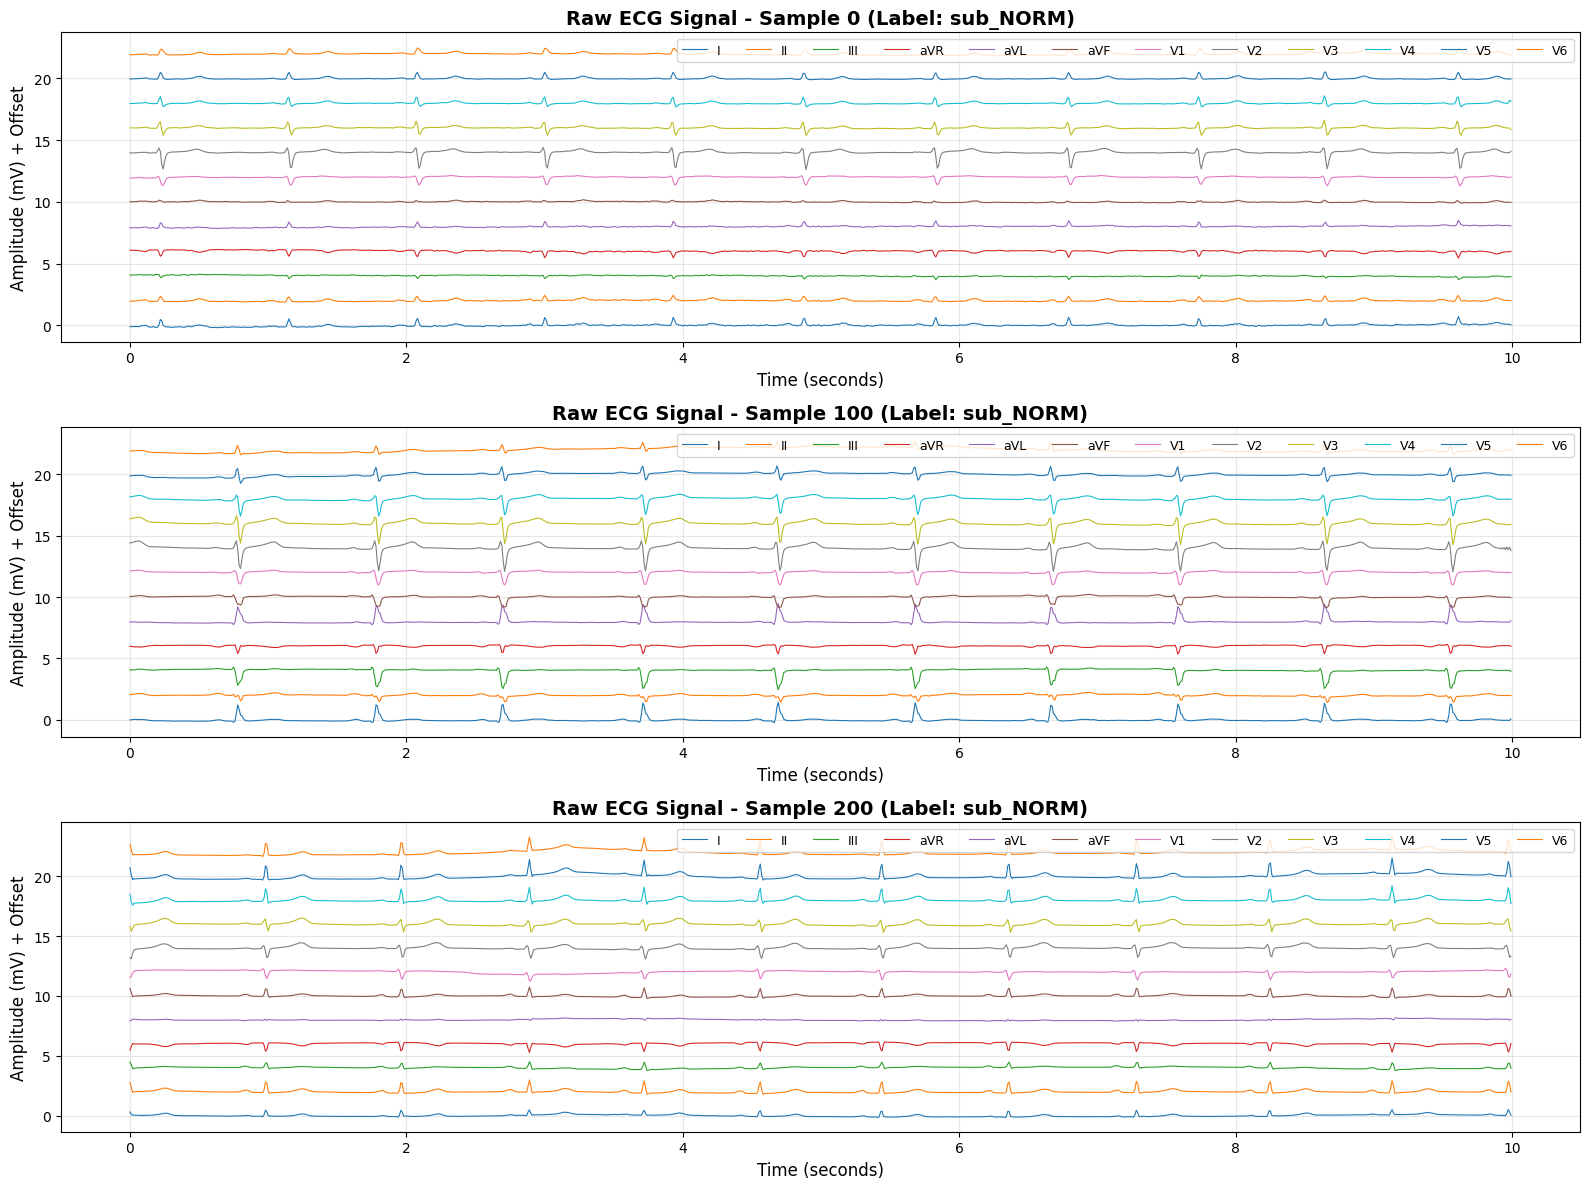

Raw signal shape (time, channels): (1000, 12)
Value range: [-20.0320, 17.2120]
Mean: -0.0009, Std: 0.2226
Sampling rate assumed for visualizations: 100 Hz


In [ ]:
import matplotlib.pyplot as plt
import numpy as np

SAMPLING_RATE = 100  # Hz sampling rate used by PTB-XL low-resolution signals

# Select a few samples to visualize
sample_indices = [0, 100, 200]  # Different samples
lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

for idx, sample_idx in enumerate(sample_indices):
    # Get raw signal
    raw_signal = X_train_filtered[sample_idx]  # Shape: (time_steps, 12)
    label = y_train_int[sample_idx]
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(raw_signal.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        # Offset each lead for visibility
        offset = lead_idx * 2
        ax.plot(time_axis, raw_signal[:, lead_idx] + offset, label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Amplitude (mV) + Offset', fontsize=12)
    ax.set_title(f'Raw ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Raw signal shape (time, channels): {raw_signal.shape}")
print(f"Value range: [{X_train_filtered.min():.4f}, {X_train_filtered.max():.4f}]")
print(f"Mean: {X_train_filtered.mean():.4f}, Std: {X_train_filtered.std():.4f}")
print(f"Sampling rate assumed for visualizations: {SAMPLING_RATE} Hz")

## Visualization: After Preprocessing (Normalized)

Now let's see the same signals after preprocessing (normalization).
Each tensor coming from `train_dataset_classification` is already shaped as `(time_steps, channels)`,
so the plots below directly reuse that convention and only offset each lead for readability.

Example preprocessed tensor shape (time, channels): (1000, 12)


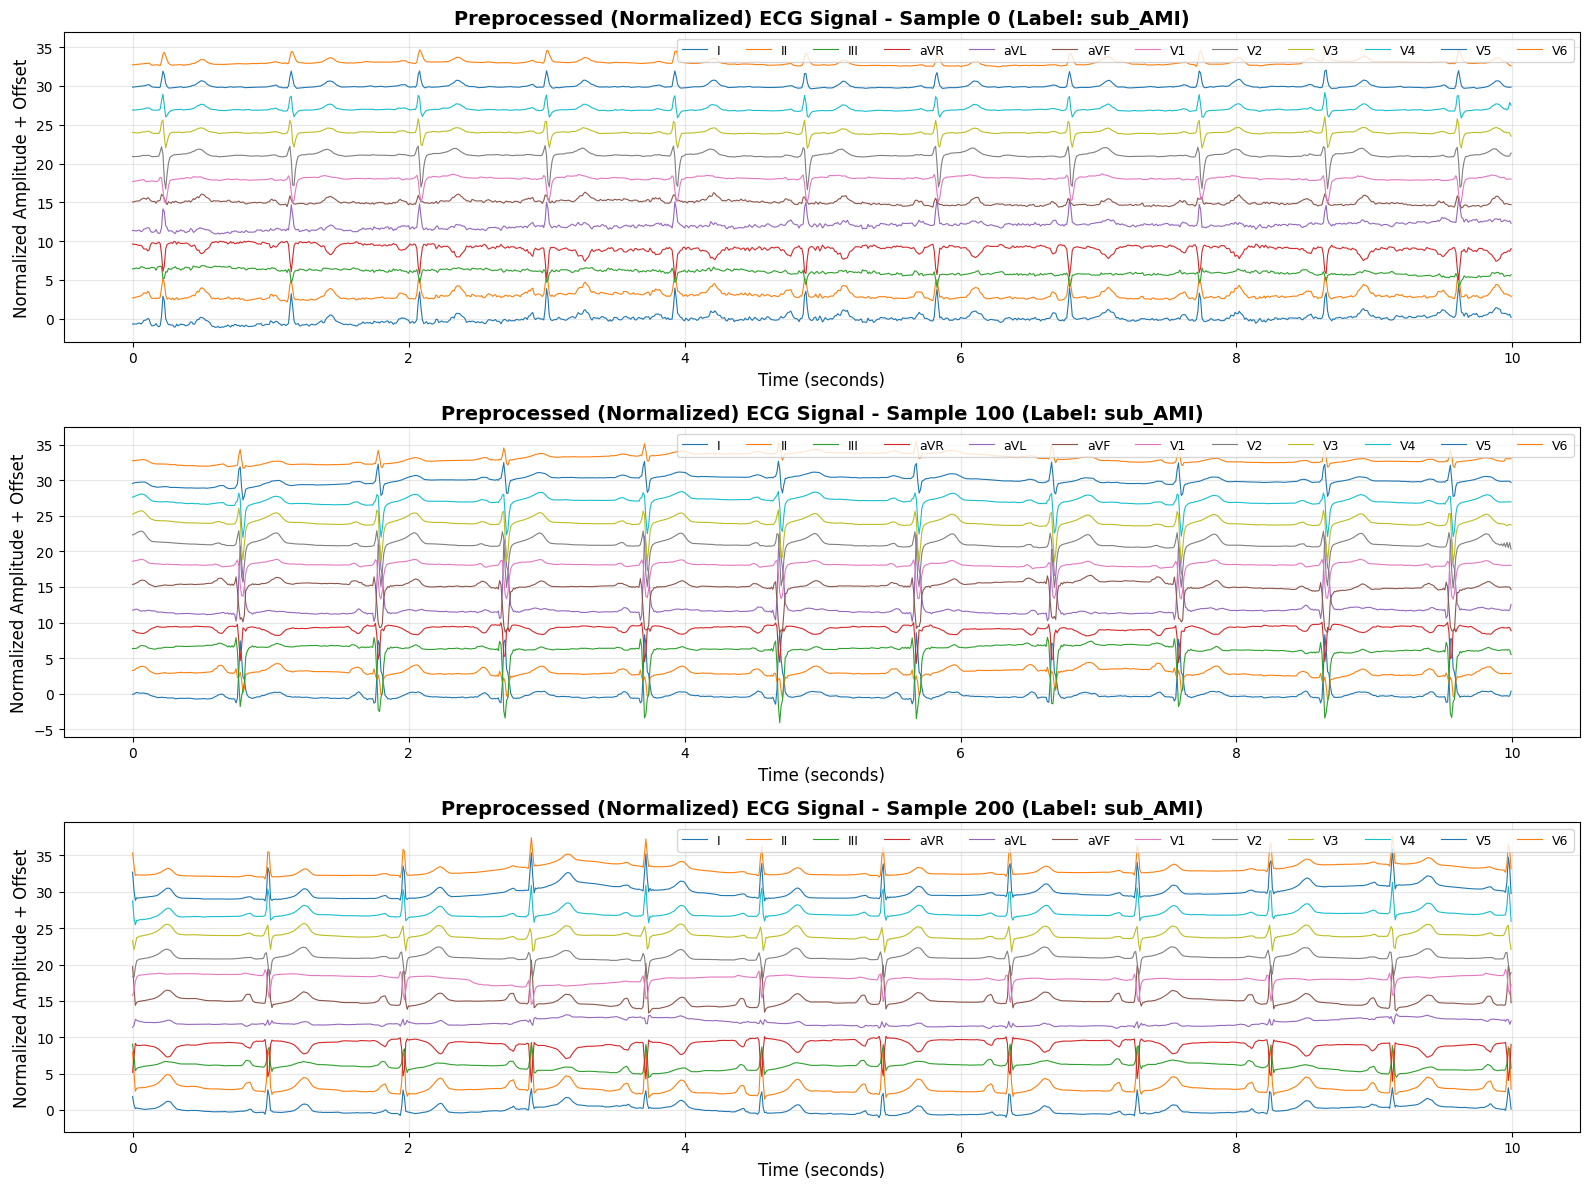

Preprocessed signal shape (time, channels): (1000, 12)
Value range: [-5.2083, 6.2728]
Mean per channel: 0.017460
Std per channel: 0.696095

Normalization stats used:
  Channel means: min=-0.0029, max=0.0020
  Channel stds: min=0.132004, max=0.313382


In [ ]:
fig, axes = plt.subplots(len(sample_indices), 1, figsize=(16, 4 * len(sample_indices)))
if len(sample_indices) == 1:
    axes = [axes]

dataset_shape_logged = False
last_preprocessed_np = None

for idx, sample_idx in enumerate(sample_indices):
    # Get preprocessed signal from the dataset (time_steps, num_channels)
    preprocessed_signal, label = train_dataset_classification[sample_idx]
    preprocessed_np = preprocessed_signal.numpy()
    last_preprocessed_np = preprocessed_np
    
    if not dataset_shape_logged:
        print(f"Example preprocessed tensor shape (time, channels): {preprocessed_np.shape}")
        dataset_shape_logged = True
    
    ax = axes[idx]
    
    # Plot all 12 leads
    time_axis = np.arange(preprocessed_np.shape[0]) / SAMPLING_RATE
    
    for lead_idx in range(12):
        offset = lead_idx * 3  # Slightly larger offset for normalized data
        ax.plot(time_axis, preprocessed_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8)
    
    ax.set_xlabel('Time (seconds)', fontsize=12)
    ax.set_ylabel('Normalized Amplitude + Offset', fontsize=12)
    ax.set_title(f'Preprocessed (Normalized) ECG Signal - Sample {sample_idx} (Label: {idx_to_label[label]})', 
                 fontsize=14, fontweight='bold')
    ax.legend(ncol=12, loc='upper right', fontsize=9)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

if last_preprocessed_np is not None:
    print(f"Preprocessed signal shape (time, channels): {last_preprocessed_np.shape}")
    print(f"Value range: [{last_preprocessed_np.min():.4f}, {last_preprocessed_np.max():.4f}]")
    print(f"Mean per channel: {last_preprocessed_np.mean(axis=0).mean():.6f}")
    print(f"Std per channel: {last_preprocessed_np.std(axis=0).mean():.6f}")
print(f"\nNormalization stats used:")
print(f"  Channel means: min={train_dataset_classification.channel_means.min():.4f}, max={train_dataset_classification.channel_means.max():.4f}")
print(f"  Channel stds: min={train_dataset_classification.channel_stds.min():.6f}, max={train_dataset_classification.channel_stds.max():.6f}")

## Visualization: After Augmentation (Contrastive Learning)

Finally, let's see how augmentations create two different views of the same signal for contrastive learning.
The augmented tensors also follow the `(time_steps, channels)` layout, which keeps the interpretation consistent across the pipeline.

Augmented tensor shape (time, channels): (1000, 12)
Pair 1 - Cosine Similarity: 0.2593
  Within target range [0.35, 0.8]? False
Pair 2 - Cosine Similarity: 0.9678
  Within target range [0.35, 0.8]? False
Pair 3 - Cosine Similarity: 0.7219
  Within target range [0.35, 0.8]? True


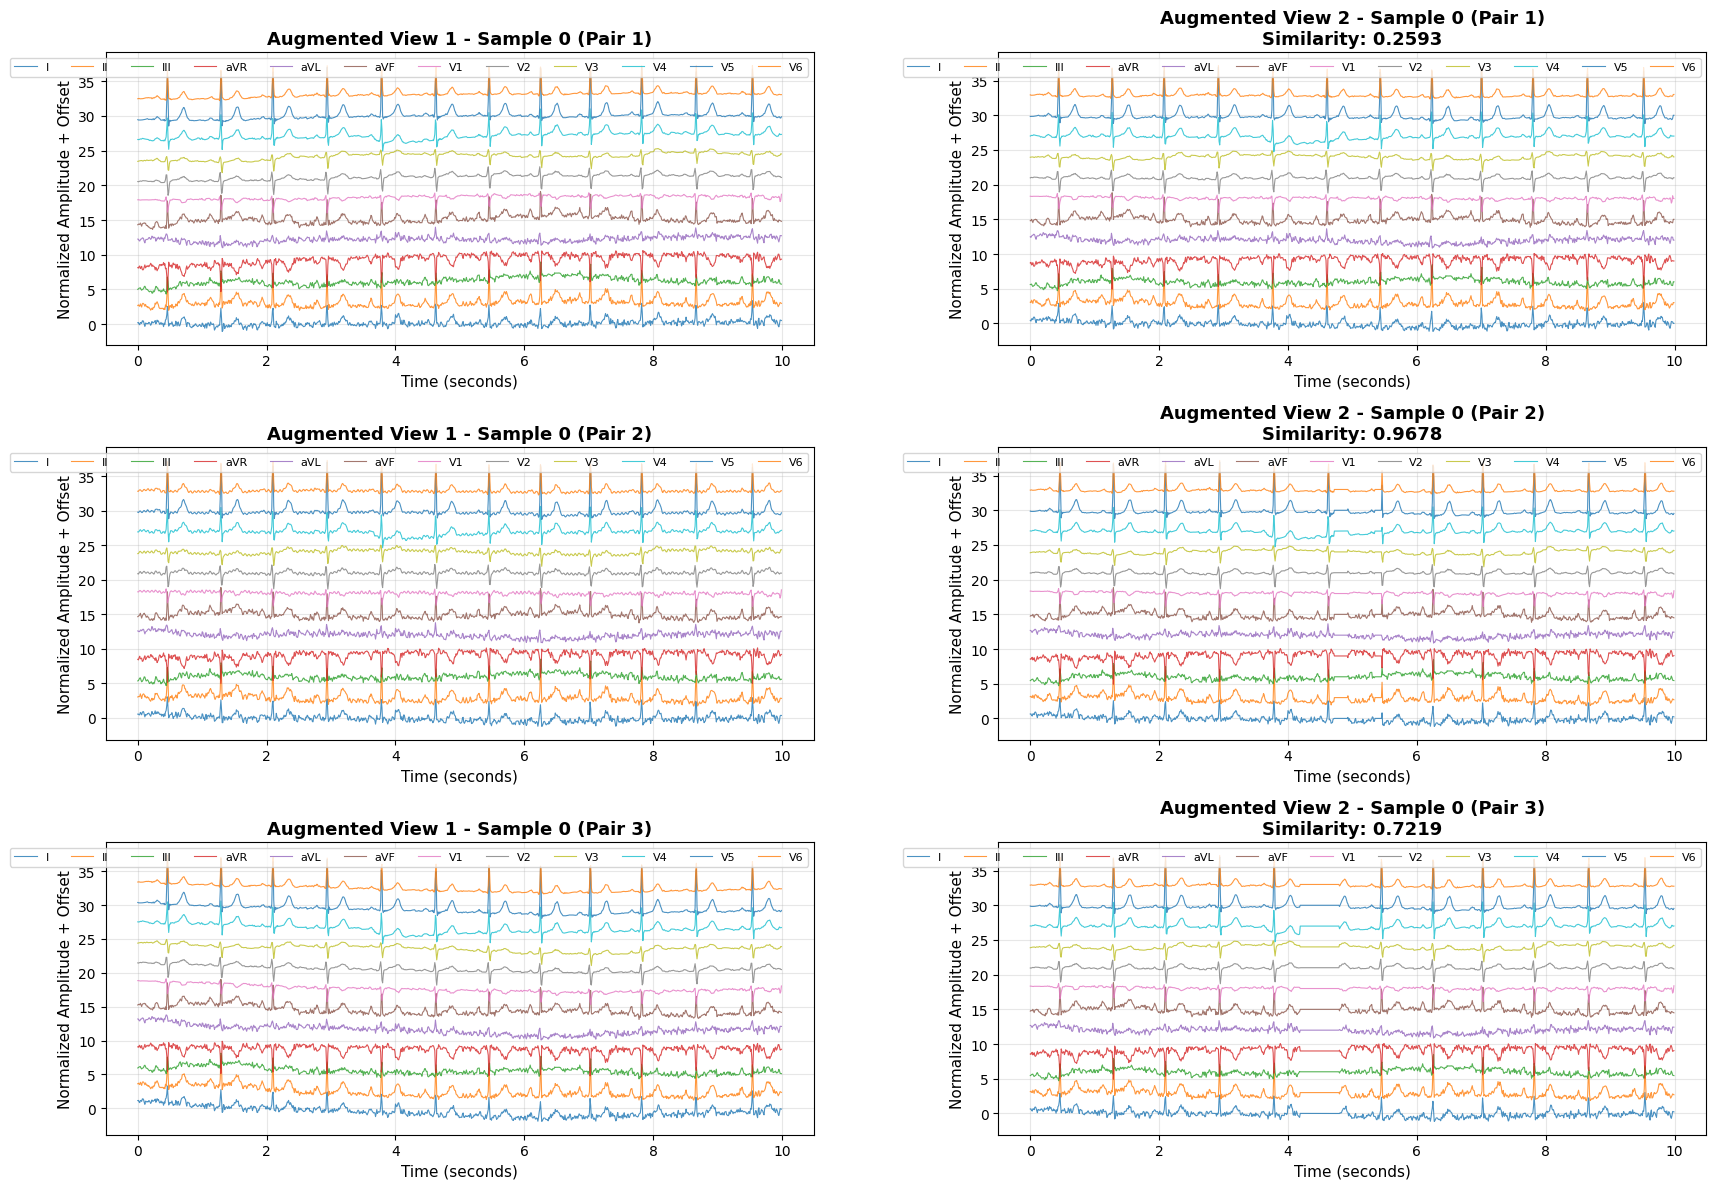


✓ Augmentation creates controlled diversity:
  Min similarity threshold: 0.35
  Max similarity threshold: 0.8
  This ensures views are similar but not identical for effective contrastive learning.


In [ ]:
from scipy.spatial.distance import cosine

# Select one sample to show augmentations
sample_idx = 0
n_views = 3  # Show 3 different augmentation pairs

fig, axes = plt.subplots(n_views, 2, figsize=(18, 4 * n_views))

for view_idx in range(n_views):
    # Get augmented views from contrastive dataset (time_steps, num_channels)
    aug1, aug2 = train_dataset[sample_idx]
    aug1_np = aug1.numpy()
    aug2_np = aug2.numpy()
    
    if view_idx == 0:
        print(f"Augmented tensor shape (time, channels): {aug1_np.shape}")
    
    # Calculate similarity between the two views
    similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
    
    time_axis = np.arange(aug1_np.shape[0]) / SAMPLING_RATE
    
    # Plot first augmented view
    ax1 = axes[view_idx, 0]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax1.plot(time_axis, aug1_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax1.set_xlabel('Time (seconds)', fontsize=11)
    ax1.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax1.set_title(f'Augmented View 1 - Sample {sample_idx} (Pair {view_idx + 1})', 
                 fontsize=13, fontweight='bold')
    ax1.legend(ncol=12, loc='upper right', fontsize=8)
    ax1.grid(True, alpha=0.3)
    
    # Plot second augmented view
    ax2 = axes[view_idx, 1]
    for lead_idx in range(12):
        offset = lead_idx * 3
        ax2.plot(time_axis, aug2_np[:, lead_idx] + offset, 
                label=lead_names[lead_idx], linewidth=0.8, alpha=0.8)
    
    ax2.set_xlabel('Time (seconds)', fontsize=11)
    ax2.set_ylabel('Normalized Amplitude + Offset', fontsize=11)
    ax2.set_title(f'Augmented View 2 - Sample {sample_idx} (Pair {view_idx + 1})\nSimilarity: {similarity:.4f}', 
                 fontsize=13, fontweight='bold')
    ax2.legend(ncol=12, loc='upper right', fontsize=8)
    ax2.grid(True, alpha=0.3)
    
    print(f"Pair {view_idx + 1} - Cosine Similarity: {similarity:.4f}")
    print(f"  Within target range [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]? "
          f"{dual_augmenter.min_similarity <= similarity <= dual_augmenter.max_similarity}")

plt.tight_layout()
plt.show()

print(f"\n✓ Augmentation creates controlled diversity:")
print(f"  Min similarity threshold: {dual_augmenter.min_similarity}")
print(f"  Max similarity threshold: {dual_augmenter.max_similarity}")
print(f"  This ensures views are similar but not identical for effective contrastive learning.")

## Visualization: Side-by-Side Comparison

Let's create a comprehensive comparison showing raw, preprocessed, and augmented versions of the same signal,
keeping the `(time_steps, channels)` orientation consistent at every stage.

Side-by-side tensor shapes (time, channels): raw=(1000, 12), preprocessed=(1000, 12), aug=(1000, 12)


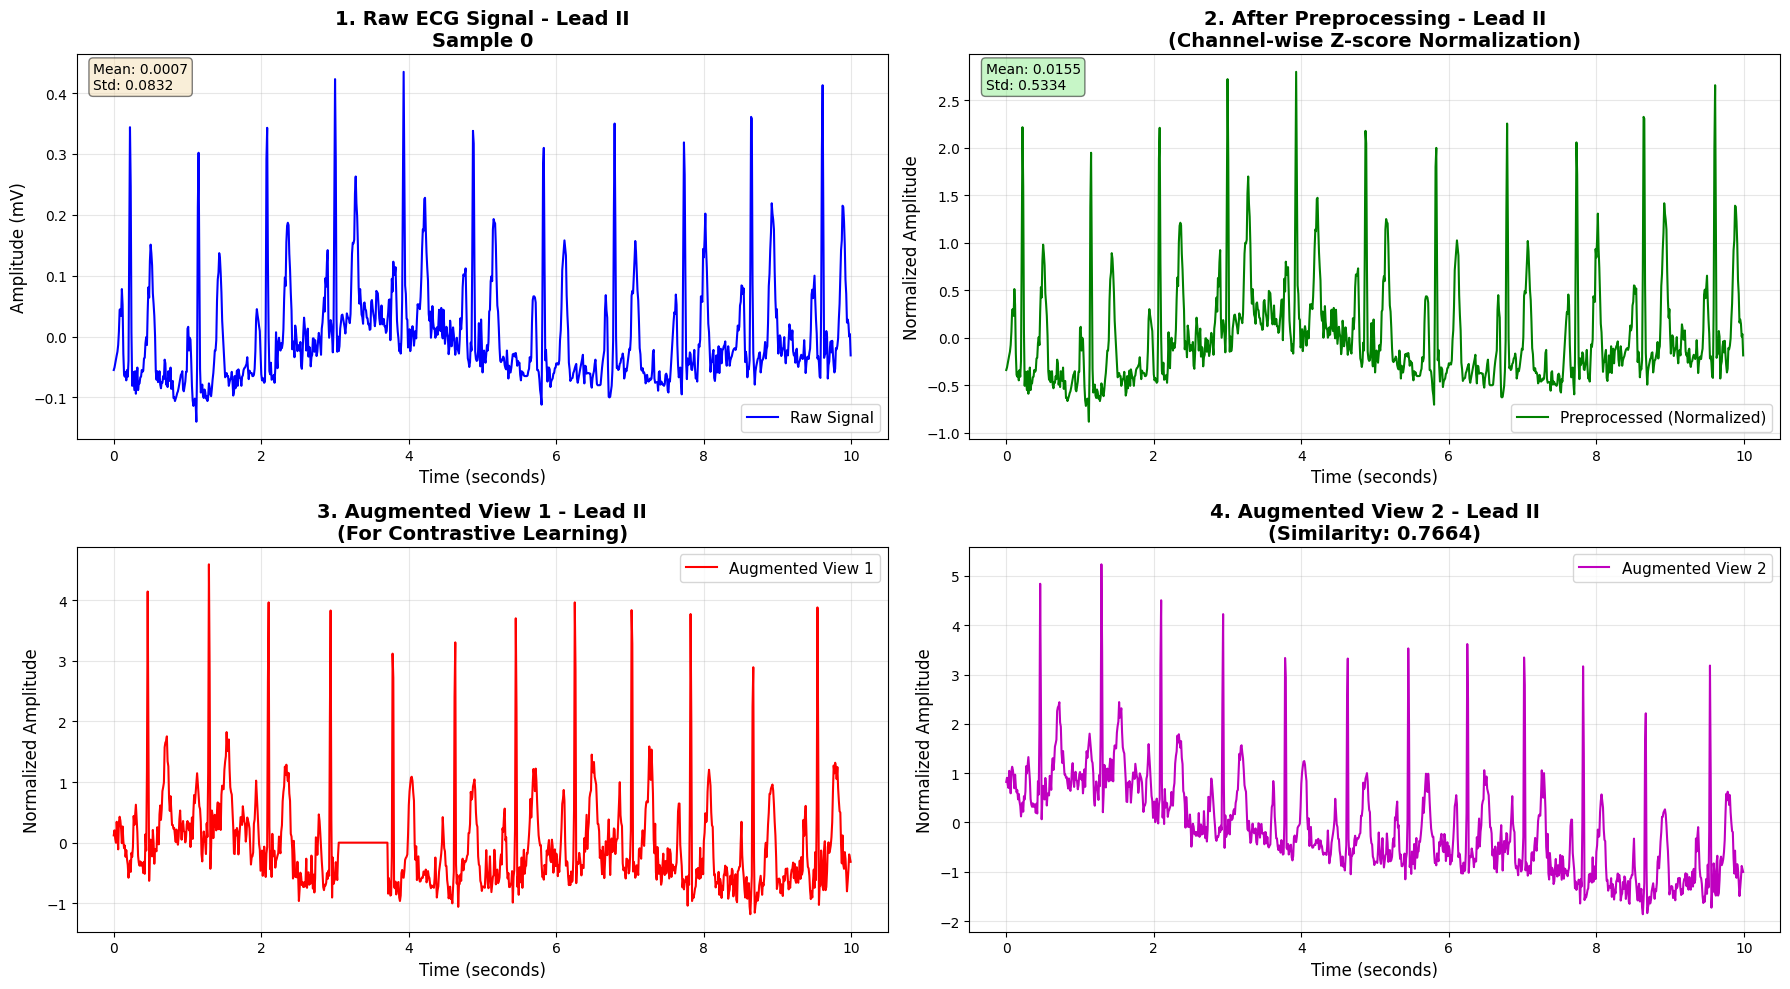

DATA PREPROCESSING PIPELINE SUMMARY

1. RAW DATA:
   - Shape (time, channels): (1000,)
   - Range: [-0.1400, 0.4350]
   - Mean: 0.0007, Std: 0.0832

2. AFTER PREPROCESSING (Normalization):
   - Channel-wise Z-score normalization: (x - mean) / std
   - Shape (time, channels): (1000,)
   - Range: [-0.8864, 2.7989]
   - Mean: 0.015502, Std: 0.5334

3. AFTER AUGMENTATION:
   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,
     RespirationNoise, AmplitudeScale, TimeCutout
   - Two views created with controlled similarity: [0.35, 0.8]
   - Actual similarity: 0.7664
   - View 1 range: [-1.1813, 4.5935]
   - View 2 range: [-1.8611, 5.2342]



In [ ]:
# Pick a sample and show one lead for clarity
sample_idx = 0
lead_idx = 1  # Lead II (commonly used in ECG analysis)

# Get the data at different stages
raw_signal = X_train_filtered[sample_idx][:, lead_idx]
preprocessed_signal, _ = train_dataset_classification[sample_idx]
preprocessed_np = preprocessed_signal.numpy()
aug1, aug2 = train_dataset[sample_idx]
aug1_np = aug1.numpy()
aug2_np = aug2.numpy()

print(f"Side-by-side tensor shapes (time, channels): raw={X_train_filtered[sample_idx].shape}, preprocessed={preprocessed_np.shape}, aug={aug1_np.shape}")

preprocessed_signal = preprocessed_np[:, lead_idx]
aug1_signal = aug1_np[:, lead_idx]
aug2_signal = aug2_np[:, lead_idx]

time_axis = np.arange(len(raw_signal)) / SAMPLING_RATE

fig, axes = plt.subplots(2, 2, figsize=(18, 10))

# Raw signal
axes[0, 0].plot(time_axis, raw_signal, 'b-', linewidth=1.5, label='Raw Signal')
axes[0, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 0].set_ylabel('Amplitude (mV)', fontsize=12)
axes[0, 0].set_title(f'1. Raw ECG Signal - Lead {lead_names[lead_idx]}\nSample {sample_idx}', 
                     fontsize=14, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].text(0.02, 0.98, f'Mean: {raw_signal.mean():.4f}\nStd: {raw_signal.std():.4f}',
                transform=axes[0, 0].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

# Preprocessed signal
axes[0, 1].plot(time_axis, preprocessed_signal, 'g-', linewidth=1.5, label='Preprocessed (Normalized)')
axes[0, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[0, 1].set_ylabel('Normalized Amplitude', fontsize=12)
axes[0, 1].set_title(f'2. After Preprocessing - Lead {lead_names[lead_idx]}\n(Channel-wise Z-score Normalization)', 
                     fontsize=14, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].text(0.02, 0.98, f'Mean: {preprocessed_signal.mean():.4f}\nStd: {preprocessed_signal.std():.4f}',
                transform=axes[0, 1].transAxes, fontsize=10, verticalalignment='top',
                bbox=dict(boxstyle='round', facecolor='lightgreen', alpha=0.5))

# Augmented view 1
axes[1, 0].plot(time_axis, aug1_signal, 'r-', linewidth=1.5, label='Augmented View 1')
axes[1, 0].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 0].set_ylabel('Normalized Amplitude', fontsize=12)
axes[1, 0].set_title(f'3. Augmented View 1 - Lead {lead_names[lead_idx]}\n(For Contrastive Learning)', 
                     fontsize=14, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# Augmented view 2
axes[1, 1].plot(time_axis, aug2_signal, 'm-', linewidth=1.5, label='Augmented View 2')
axes[1, 1].set_xlabel('Time (seconds)', fontsize=12)
axes[1, 1].set_ylabel('Normalized Amplitude', fontsize=12)
similarity = 1 - cosine(aug1_np.flatten(), aug2_np.flatten())
axes[1, 1].set_title(f'4. Augmented View 2 - Lead {lead_names[lead_idx]}\n(Similarity: {similarity:.4f})', 
                     fontsize=14, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("=" * 80)
print("DATA PREPROCESSING PIPELINE SUMMARY")
print("=" * 80)
print(f"\n1. RAW DATA:")
print(f"   - Shape (time, channels): {raw_signal.shape}")
print(f"   - Range: [{raw_signal.min():.4f}, {raw_signal.max():.4f}]")
print(f"   - Mean: {raw_signal.mean():.4f}, Std: {raw_signal.std():.4f}")

print(f"\n2. AFTER PREPROCESSING (Normalization):")
print(f"   - Channel-wise Z-score normalization: (x - mean) / std")
print(f"   - Shape (time, channels): {preprocessed_signal.shape}")
print(f"   - Range: [{preprocessed_signal.min():.4f}, {preprocessed_signal.max():.4f}]")
print(f"   - Mean: {preprocessed_signal.mean():.6f}, Std: {preprocessed_signal.std():.4f}")

print(f"\n3. AFTER AUGMENTATION:")
print(f"   - Applied random augmentations from pool: TimeShift, GaussNoise, PowerlineNoise,")
print(f"     RespirationNoise, AmplitudeScale, TimeCutout")
print(f"   - Two views created with controlled similarity: [{dual_augmenter.min_similarity}, {dual_augmenter.max_similarity}]")
print(f"   - Actual similarity: {similarity:.4f}")
print(f"   - View 1 range: [{aug1_signal.min():.4f}, {aug1_signal.max():.4f}]")
print(f"   - View 2 range: [{aug2_signal.min():.4f}, {aug2_signal.max():.4f}]")

print("\n" + "=" * 80)

# Evaluation Pipeline
We will plot the test-set in 2-d using PCA and add the labels as the colors.

In [7]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt
import numpy as np
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from umap.umap_ import UMAP
from pyclustertend import hopkins
import matplotlib.pyplot as plt

def extract_embeddings(model, dataloader, device=None):
    """
    Extract embeddings and labels from the model for a given dataset.
    
    Args:
        model: Trained ECGEncoder
        dataloader: DataLoader with (signal, label) pairs
        device: Device to run inference on
        
    Returns:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    """
    if device is None:
        device = next(model.parameters()).device
    
    model.eval()
    all_embeddings = []
    all_labels = []
    
    with torch.no_grad():
        for signals, labels in dataloader:
            signals = signals.to(device)
            representations, _ = model(signals)  # Use representations, not projections
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            # Labels are already integers from ECGDataset
            all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)
    
    embeddings = np.concatenate(all_embeddings, axis=0)
    labels_array = np.array(all_labels, dtype=int)
    return embeddings, labels_array


def plot_embeddings_2d(embeddings, labels, method='pca', title='ECG Embeddings Visualization', 
                        figsize=(12, 8), label_names=None):
    """
    Plot embeddings in 2D using PCA, t-SNE, or UMAP.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels for each sample
        method: 'pca', 'tsne', or 'umap'
        title: Plot title
        figsize: Figure size
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    # Ensure labels are numpy array
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Reduce to 2D
    if method == 'pca':
        reducer = PCA(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        explained_var = reducer.explained_variance_ratio_
        subtitle = f'Explained variance: {explained_var[0]:.2%} (PC1), {explained_var[1]:.2%} (PC2)'
    elif method == 'tsne':
        reducer = TSNE(n_components=2, random_state=42, perplexity=30)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = 't-SNE projection'
    elif method == 'umap':
        reducer = UMAP(n_components=2, random_state=42)
        embeddings_2d = reducer.fit_transform(embeddings)
        subtitle = f'UMAP projection (n_neighbors={reducer.n_neighbors}, min_dist={reducer.min_dist})'
    else:
        raise ValueError("method must be 'pca', 'tsne', or 'umap'")
    
    # Get unique labels
    unique_labels = np.unique(labels)
    
    # Plot
    fig, ax = plt.subplots(figsize=figsize)
    scatter = ax.scatter(
        embeddings_2d[:, 0], 
        embeddings_2d[:, 1], 
        c=labels, 
        cmap='tab10', 
        alpha=0.6,
        s=20
    )
    
    # Add legend with optional label names
    if label_names is not None:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=label_names.get(label, f'Class {label}')) 
                   for label in unique_labels]
    else:
        handles = [plt.Line2D([0], [0], marker='o', color='w', 
                              markerfacecolor=scatter.cmap(scatter.norm(label)), 
                              markersize=8, label=f'Class {label}') 
                   for label in unique_labels]
    
    ax.legend(handles=handles, title='Diagnostic Class', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    ax.set_xlabel('Component 1')
    ax.set_ylabel('Component 2')
    ax.set_title(f'{title}\n{subtitle}')
    ax.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    return embeddings_2d, unique_labels


def calculate_clustering_metrics(embeddings, labels):
    """
    Calculate clustering quality metrics, including the Hopkins statistic for cluster tendency.
    
    Args:
        embeddings: numpy array of shape (n_samples, d_model)
        labels: numpy array of integer labels
    
    Returns:
        Dictionary with clustering metrics
    """
    # Ensure labels are numpy array of integers
    if not isinstance(labels, np.ndarray):
        labels = np.array(labels, dtype=int)
    
    # Get unique labels and their counts
    unique_labels, counts = np.unique(labels, return_counts=True)
    
    n_samples = embeddings.shape[0]

    # Hopkins statistic for cluster tendency.
    # The sampling size must be smaller than the number of samples.
    # A value close to 1 indicates a high tendency to cluster.
    # A value close to 0.5 indicates random data.
    sampling_size = n_samples - 1
    hopkins_stat = hopkins(embeddings, sampling_size)

    # Calculate metrics
    metrics = {
        'hopkins_statistic': hopkins_stat,
        'silhouette_score': silhouette_score(embeddings, labels),
        'davies_bouldin_score': davies_bouldin_score(embeddings, labels),
        'calinski_harabasz_score': calinski_harabasz_score(embeddings, labels),
        'n_samples': n_samples,
        'n_classes': len(unique_labels),
        'class_distribution': {int(label): int(count) for label, count in zip(unique_labels, counts)}
    }
    
    return metrics


def print_clustering_metrics(metrics, label_names=None):
    """
    Pretty print clustering metrics.
    
    Args:
        metrics: Dictionary of clustering metrics from calculate_clustering_metrics
        label_names: Optional dict mapping integer labels to class names (e.g., {0: 'Normal', 1: 'AF', ...})
    """
    print("=" * 60)
    print("CLUSTERING QUALITY METRICS")
    print("=" * 60)
    print(f"Number of samples: {metrics['n_samples']}")
    print(f"Number of classes: {metrics['n_classes']}")
    print()
    print("Metrics:")
    print(f"  Silhouette Score:        {metrics['silhouette_score']:.4f}")
    print(f"    (Range: [-1, 1], Higher is better)")
    print(f"    > 0.5: Strong separation")
    print(f"    > 0.3: Reasonable separation")
    print()
    print(f"  Davies-Bouldin Score:    {metrics['davies_bouldin_score']:.4f}")
    print(f"    (Range: [0, ∞], Lower is better)")
    print(f"    < 1.0: Good clustering")
    print()
    print(f"  Calinski-Harabasz Score: {metrics['calinski_harabasz_score']:.2f}")
    print(f"    (Range: [0, ∞], Higher is better)")
    print()
    print(f"  Hopkins Statistic:       {metrics['hopkins_statistic']:.4f}")
    print("Class Distribution:")
    for label, count in sorted(metrics['class_distribution'].items(), key=lambda x: x[1], reverse=True):
        percentage = (count / metrics['n_samples']) * 100
        if label_names is not None:
            label_str = label_names.get(label, f'Class {label}')
        else:
            label_str = f'Class {label}'
        print(f"  {label_str:20s}: {count:4d} samples ({percentage:5.1f}%)")
    print("=" * 60)


/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Our Architecture

Try next:
1. Replacing Sinosudial Positional Encoding with learnable weights.
2. Set-wise Channel-wise Normalization.
3. Mix of both.

In [8]:
from src import ECGModelConfig, ECGEncoder

In [12]:
from typing import Tuple


def summarize_encoder_params(model) -> Tuple[int, int]:
    """
    Print a concise summary of the encoder's parameters and return (total, trainable).
    Uses existing `ecg_encoder`, `encoder_config`, `total_params`, `trainable_params` if available.
    """
    total = sum(p.numel() for p in model.parameters())
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)

    print(f"Model: {model.__class__.__name__}")
    print(f"Total params:     {total:,}")
    print(f"Trainable params: {trainable:,}\n")

    print("Per top-level module parameter counts:")
    for name, module in model.named_children():
        mod_total = sum(p.numel() for p in module.parameters())
        mod_train = sum(p.numel()
                        for p in module.parameters() if p.requires_grad)
        print(f"  {name:20s} | total: {mod_total:10,} | trainable: {mod_train:10,}")

    return total, trainable


ecg_encoder = ECGEncoder(ECGModelConfig(sequence_length=1000,
    num_channels=12,
    encoder_embed_dim=620,
    d_model=1024,
    time_token_dim=512,
    channel_token_dim=1024,
    time_heads=4,
    channel_heads=4,
    time_layers= 6,
    channel_layers=6,
    ff_multiplier=4,
    dropout=0.01,
    temperature=0.5,
    projection_dim=512,
    time_conv_kernel_size=3,
    channel_conv_kernel_size=7,
    channel_conv_stride=1,
    dtype= torch.bfloat16,
    fusion_hidden_dim=2048,
    fusion_dropout=0.0
))

# Use the existing ecg_encoder variable in the notebook
total, trainable = summarize_encoder_params(ecg_encoder)

Model: ECGEncoder
Total params:     66,612,904
Trainable params: 66,612,904

Per top-level module parameter counts:
  time_conv_embedding  | total:    600,388 | trainable:    600,388
  time_positional_encoding | total:    620,000 | trainable:    620,000
  time_transformer     | total: 27,725,160 | trainable: 27,725,160
  channel_conv_embedding | total:    635,980 | trainable:    635,980
  channel_norm         | total:      1,240 | trainable:      1,240
  channel_dropout      | total:          0 | trainable:          0
  channel_transformer  | total: 27,725,160 | trainable: 27,725,160
  cross_attention      | total:  3,082,640 | trainable:  3,082,640
  fusion               | total:  4,645,888 | trainable:  4,645,888
  projection           | total:  1,576,448 | trainable:  1,576,448


## Training

In [14]:
import matplotlib.pyplot as plt
from torch.utils.data import Subset

train_dataset = Subset(
    ECGContrastiveTrainDataset(
        X=X_train_filtered, y=y_train_int, dual_augmenter=dual_augmenter
    ),
    indices=np.random.choice(len(X_train_filtered), size=len(
        X_train_filtered), replace=False),
)

model = ECGEncoder(ECGModelConfig(sequence_length=1000,
                                  num_channels=12,
                                  encoder_embed_dim=512,
                                  d_model=1024,
                                  time_token_dim=512,
                                  channel_token_dim=1024,
                                  time_heads=4,
                                  channel_heads=4,
                                  time_layers=6,
                                  channel_layers=6,
                                  ff_multiplier=4,
                                  dropout=0.01,
                                  temperature=0.5,
                                  projection_dim=512,
                                  time_conv_kernel_size=3,
                                  channel_conv_kernel_size=7,
                                  channel_conv_stride=1,
                                  dtype=torch.bfloat16,
                                  fusion_hidden_dim=2048,
                                  fusion_dropout=0.0
                                  ))

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)
loss_fn = NTXentLoss(temperature=0.25)

history = train(
    model=model,
    dataset=train_dataset,
    optimizer=optimizer,
    loss_fn=loss_fn,
    config=ECGModelConfig(),
    batch_size=256,
    epochs=30,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints", keep_last_n=2, save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)


plt.figure(figsize=(10, 6))
epochs_range = range(1, len(history["loss_history"]) + 1)
plt.plot(
    epochs_range,
    history["loss_history"],
    "b-",
    label="Training Loss",
    linewidth=2,
)
if "val_loss_history" in history and history["val_loss_history"]:
    plt.plot(
        epochs_range,
        history["val_loss_history"],
        "r-",
        label="Validation Loss",
        linewidth=2,
    )
plt.xlabel("Epoch", fontsize=12)
plt.ylabel("Loss", fontsize=12)
plt.title("Training and Validation Loss Over Time",
          fontsize=14, fontweight="bold")
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print final metrics
print(f"\nFinal Training Loss: {history['loss_history'][-1]:.4f}")
if "val_loss_history" in history and history["val_loss_history"]:
    print(
        f"Final Validation Loss: {history['val_loss_history'][-1]:.4f}")
    print(
        f"Best Validation Loss: {min(history['val_loss_history']):.4f} (Epoch {history['val_loss_history'].index(min(history['val_loss_history'])) + 1})"
    )

Epoch 1/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=1.6719]


Epoch [1/30] Train Loss: 4.4688 | Grad Norm: 7.84 | LR: 0.000500 | Val Loss: 3.5871 | Time: 206.2s | Total: 206.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_1.pt
New best model saved with loss: 4.4688
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 2/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.02it/s, val_loss=1.1094]


Epoch [2/30] Train Loss: 3.6012 | Grad Norm: 3.10 | LR: 0.000500 | Val Loss: 3.2188 | Time: 206.4s | Total: 420.5s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_2.pt
New best model saved with loss: 3.6012
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 3/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=1.1406]


Epoch [3/30] Train Loss: 3.3802 | Grad Norm: 2.69 | LR: 0.000500 | Val Loss: 3.0379 | Time: 206.1s | Total: 634.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_3.pt
New best model saved with loss: 3.3802
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 4/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=1.1094]


Epoch [4/30] Train Loss: 3.1514 | Grad Norm: 2.45 | LR: 0.000500 | Val Loss: 2.8549 | Time: 207.2s | Total: 850.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_4.pt
New best model saved with loss: 3.1514
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 5/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=1.0234]


Epoch [5/30] Train Loss: 3.0413 | Grad Norm: 1.91 | LR: 0.000500 | Val Loss: 2.7846 | Time: 206.6s | Total: 1064.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_5.pt
New best model saved with loss: 3.0413
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 6/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.03it/s, val_loss=1.0156]


Epoch [6/30] Train Loss: 2.9906 | Grad Norm: 1.61 | LR: 0.000500 | Val Loss: 2.6763 | Time: 206.4s | Total: 1279.1s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_6.pt
New best model saved with loss: 2.9906
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 7/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8359]


Epoch [7/30] Train Loss: 2.9248 | Grad Norm: 1.83 | LR: 0.000500 | Val Loss: 2.6083 | Time: 206.0s | Total: 1493.3s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_7.pt
New best model saved with loss: 2.9248
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 8/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.9609]


Epoch [8/30] Train Loss: 2.8638 | Grad Norm: 1.44 | LR: 0.000500 | Val Loss: 2.6685 | Time: 206.2s | Total: 1707.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_8.pt
New best model saved with loss: 2.8638
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 9/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8281]


Epoch [9/30] Train Loss: 2.8535 | Grad Norm: 1.30 | LR: 0.000500 | Val Loss: 2.5893 | Time: 206.1s | Total: 1921.5s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_9.pt
New best model saved with loss: 2.8535
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 10/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8086]


Epoch [10/30] Train Loss: 2.8104 | Grad Norm: 1.10 | LR: 0.000500 | Val Loss: 2.5686 | Time: 206.4s | Total: 2135.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_10.pt
New best model saved with loss: 2.8104
Removed old checkpoint: checkpoint_epoch_10.pt


Epoch 11/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8555]


Epoch [11/30] Train Loss: 2.7935 | Grad Norm: 1.20 | LR: 0.000500 | Val Loss: 2.5396 | Time: 206.0s | Total: 2349.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_11.pt
New best model saved with loss: 2.7935
Removed old checkpoint: checkpoint_epoch_11.pt


Epoch 12/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.7852]


Epoch [12/30] Train Loss: 2.7661 | Grad Norm: 1.09 | LR: 0.000500 | Val Loss: 2.5698 | Time: 206.5s | Total: 2564.0s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_12.pt
New best model saved with loss: 2.7661
Removed old checkpoint: checkpoint_epoch_12.pt


Epoch 13/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8477]


Epoch [13/30] Train Loss: 2.7596 | Grad Norm: 1.06 | LR: 0.000500 | Val Loss: 2.5564 | Time: 206.0s | Total: 2778.2s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_13.pt
New best model saved with loss: 2.7596
Removed old checkpoint: checkpoint_epoch_13.pt


Epoch 14/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, val_loss=0.7461]


Epoch [14/30] Train Loss: 2.7384 | Grad Norm: 1.12 | LR: 0.000500 | Val Loss: 2.4771 | Time: 206.4s | Total: 2992.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_14.pt
New best model saved with loss: 2.7384
Removed old checkpoint: checkpoint_epoch_14.pt


Epoch 15/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.8867]


Epoch [15/30] Train Loss: 2.7321 | Grad Norm: 1.27 | LR: 0.000500 | Val Loss: 2.4771 | Time: 206.2s | Total: 3206.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_15.pt
New best model saved with loss: 2.7321
Removed old checkpoint: checkpoint_epoch_15.pt


Epoch 16/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.7617]


Epoch [16/30] Train Loss: 2.6753 | Grad Norm: 0.78 | LR: 0.000250 | Val Loss: 2.4347 | Time: 206.5s | Total: 3421.7s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_16.pt
New best model saved with loss: 2.6753
Removed old checkpoint: checkpoint_epoch_16.pt


Epoch 17/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.6875]


Epoch [17/30] Train Loss: 2.6585 | Grad Norm: 0.75 | LR: 0.000250 | Val Loss: 2.4040 | Time: 206.1s | Total: 3635.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_17.pt
New best model saved with loss: 2.6585
Removed old checkpoint: checkpoint_epoch_17.pt


Epoch 18/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.07it/s, val_loss=0.6680]


Epoch [18/30] Train Loss: 2.6463 | Grad Norm: 0.72 | LR: 0.000250 | Val Loss: 2.4035 | Time: 206.1s | Total: 3849.8s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_18.pt
New best model saved with loss: 2.6463
Removed old checkpoint: checkpoint_epoch_18.pt


Epoch 19/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.6523]


Epoch [19/30] Train Loss: 2.6427 | Grad Norm: 0.76 | LR: 0.000250 | Val Loss: 2.4057 | Time: 206.3s | Total: 4063.9s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_19.pt
New best model saved with loss: 2.6427
Removed old checkpoint: checkpoint_epoch_19.pt


Epoch 20/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.6992]


Epoch [20/30] Train Loss: 2.6401 | Grad Norm: 0.78 | LR: 0.000250 | Val Loss: 2.4012 | Time: 206.6s | Total: 4278.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_20.pt
New best model saved with loss: 2.6401
Removed old checkpoint: checkpoint_epoch_20.pt


Epoch 21/30 [Val]: 100%|██████████| 7/7 [00:06<00:00,  1.06it/s, val_loss=0.7383]


Epoch [21/30] Train Loss: 2.6418 | Grad Norm: 0.83 | LR: 0.000250 | Val Loss: 2.3956 | Time: 207.2s | Total: 4493.6s
Saved checkpoint: ../models/checkpoints/checkpoint_epoch_21.pt
Removed old checkpoint: checkpoint_epoch_21.pt


Epoch 22/30 [Train]:   0%|          | 0/48 [00:01<?, ?it/s]


KeyboardInterrupt: 

## Evaluation

In [21]:
Y_test_superclasses_dense = Y_test_superclasses.argmax(axis=1)
Y_train_superclasses_dense = Y_train_superclasses.argmax(axis=1)

In [ ]:
model = ecg_encoder
model.eval()
# Extract embeddings from the test set
print("Extracting embeddings from test set...")
test_dataset = ECGDataset(
    X=X_test_filtered,
    y=Y_test_superclasses_dense,
)
train_eval_dataset = ECGDataset(
    X=X_train_filtered,
    y=Y_train_superclasses_dense,
)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False)
embeddings, labels = extract_embeddings(model, test_loader)
print(f"Extracted {len(embeddings)} embeddings with dimension {embeddings.shape[1]}")
print(f"Found {len(set(labels))} unique classes: {sorted(set(labels))}")

Extracting embeddings from test set...


KeyboardInterrupt: 

In [ ]:
# Calculate and print clustering metrics
metrics = calculate_clustering_metrics(embeddings, labels)
print_clustering_metrics(metrics)

CLUSTERING QUALITY METRICS
Number of samples: 1561
Number of classes: 5

Metrics:
  Silhouette Score:        -0.0168
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    7.8849
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 9.89
    (Range: [0, ∞], Higher is better)

  Hopkins Statistic:       0.1545
Class Distribution:
  Class 0             :  913 samples ( 58.5%)
  Class 2             :  227 samples ( 14.5%)
  Class 1             :  208 samples ( 13.3%)
  Class 4             :  159 samples ( 10.2%)
  Class 3             :   54 samples (  3.5%)



Generating t-SNE visualization...


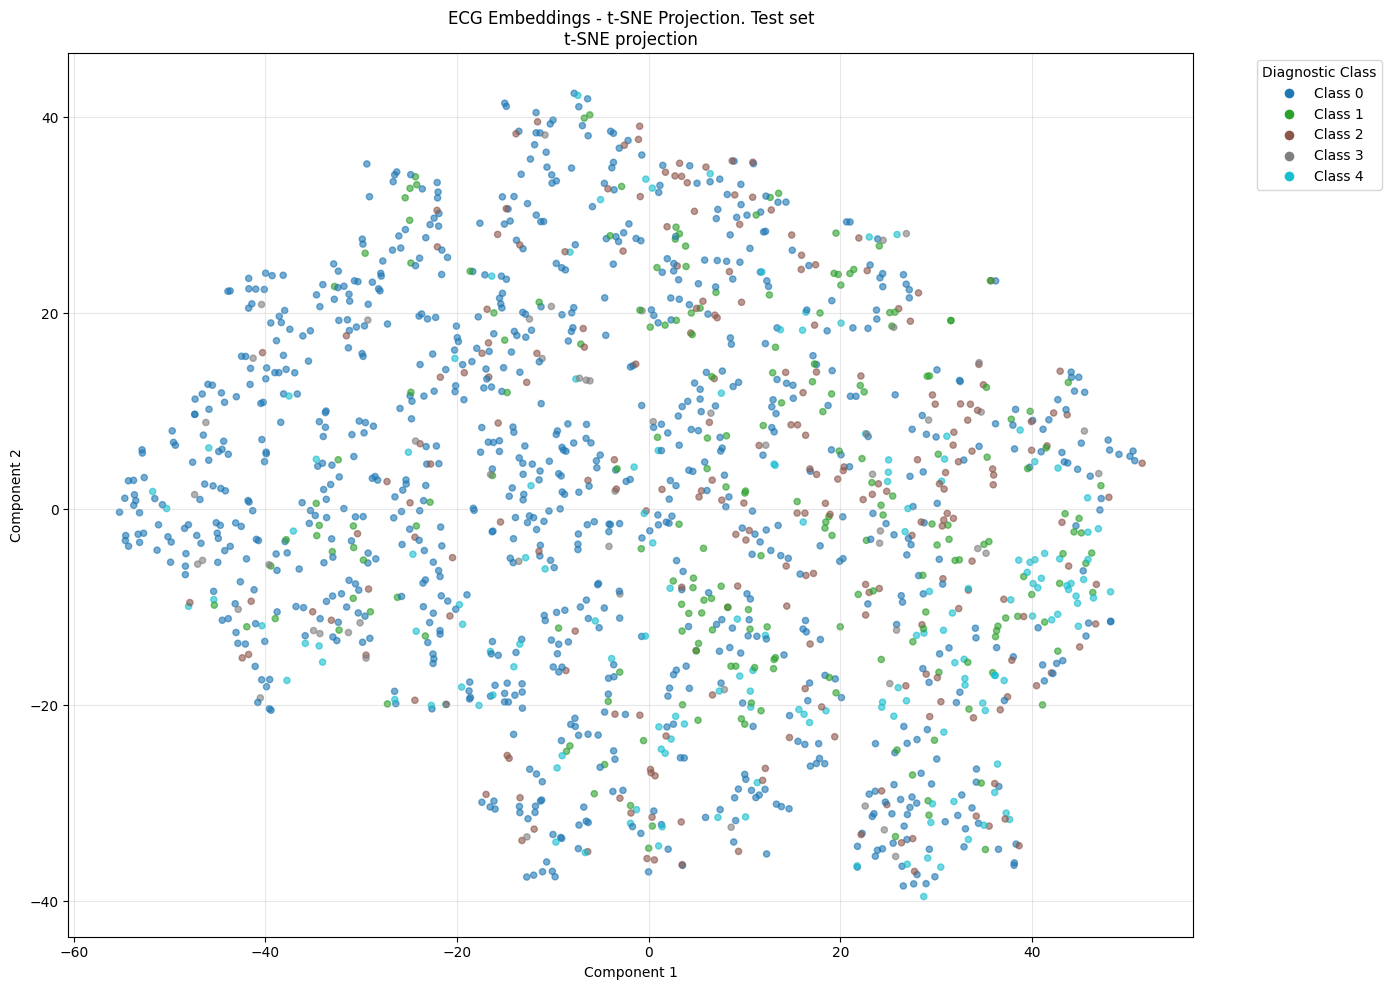

In [ ]:
# Visualize embeddings with t-SNE (optional, takes longer)
print("\nGenerating t-SNE visualization...")
embeddings_2d_tsne, _ = plot_embeddings_2d(
    embeddings, 
    labels, 
    method='tsne', 
    title='ECG Embeddings - t-SNE Projection. Test set',
    figsize=(14, 10)
)

# Baseline Model: 1D ResNet for ECG

This is a simpler baseline model based on ResNet architecture, commonly used in time-series classification papers:
- **Paper**: "Deep Residual Learning for Image Recognition" (He et al., 2015)
- **Adapted for 1D signals**: Used in many ECG papers including "Cardiologist-level arrhythmia detection" (Rajpurkar et al., 2017)
- **Architecture**: ResNet-18 style with 1D convolutions
- **Benefits**: Proven architecture, easier to train, fewer parameters

## Model Architecture

In [ ]:
from src import SimpleECGEncoder, SimpleECGConfig

In [ ]:
# Initialize simple model with same training setup
simple_model = SimpleECGEncoder(SimpleECGConfig())
simple_optimizer = torch.optim.AdamW(simple_model.parameters(), lr=1e-4)  # Slightly higher LR for simpler model
simple_loss_fn = NTXentLoss(temperature=0.5)

# Train the baseline model
print("Training simple ResNet baseline model...")
print("=" * 80)

simple_history = train(
    model=simple_model,
    dataset=train_dataset,
    optimizer=simple_optimizer,
    loss_fn=simple_loss_fn,
    config=SimpleECGConfig(),
    batch_size=128,
    epochs=30,
    checkpoint_manager=CheckpointManager(
        checkpoint_dir="../models/checkpoints_simple",
        keep_last_n=2,
        save_best=True
    ),
    resume_from=None,
    val_dataset=val_dataset,
)

Training simple ResNet baseline model...


Epoch 1/30 [Train]:  78%|███████▊  | 74/95 [00:19<00:05,  3.75it/s, loss=3.8430, grad_norm=0.96]

Epoch 1/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s, val_loss=1.9432]


Epoch [1/30] Train Loss: 4.0444 | Grad Norm: 1.21 | LR: 0.000100 | Val Loss: 3.6355 | Time: 24.5s | Total: 24.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_1.pt
New best model saved with loss: 4.0444


Epoch 2/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.14it/s, val_loss=1.9702]


Epoch [2/30] Train Loss: 3.7803 | Grad Norm: 0.82 | LR: 0.000100 | Val Loss: 3.5928 | Time: 23.6s | Total: 51.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_2.pt
New best model saved with loss: 3.7803


Epoch 3/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s, val_loss=1.9080]


Epoch [3/30] Train Loss: 3.7422 | Grad Norm: 0.71 | LR: 0.000100 | Val Loss: 3.5652 | Time: 23.4s | Total: 79.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_3.pt
New best model saved with loss: 3.7422
Removed old checkpoint: checkpoint_epoch_1.pt


Epoch 4/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, val_loss=1.9208]


Epoch [4/30] Train Loss: 3.7254 | Grad Norm: 0.64 | LR: 0.000100 | Val Loss: 3.5705 | Time: 23.6s | Total: 107.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_4.pt
New best model saved with loss: 3.7254
Removed old checkpoint: checkpoint_epoch_2.pt


Epoch 5/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.98it/s, val_loss=1.8679]


Epoch [5/30] Train Loss: 3.7115 | Grad Norm: 0.59 | LR: 0.000100 | Val Loss: 3.5364 | Time: 23.5s | Total: 134.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_5.pt
New best model saved with loss: 3.7115
Removed old checkpoint: checkpoint_epoch_3.pt


Epoch 6/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.87it/s, val_loss=1.8804]


Epoch [6/30] Train Loss: 3.7021 | Grad Norm: 0.55 | LR: 0.000100 | Val Loss: 3.5374 | Time: 23.4s | Total: 162.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_6.pt
New best model saved with loss: 3.7021
Removed old checkpoint: checkpoint_epoch_4.pt


Epoch 7/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.46it/s, val_loss=1.8851]


Epoch [7/30] Train Loss: 3.6951 | Grad Norm: 0.52 | LR: 0.000100 | Val Loss: 3.5290 | Time: 24.0s | Total: 190.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_7.pt
New best model saved with loss: 3.6951
Removed old checkpoint: checkpoint_epoch_5.pt


Epoch 8/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s, val_loss=1.8511]


Epoch [8/30] Train Loss: 3.6888 | Grad Norm: 0.50 | LR: 0.000100 | Val Loss: 3.5180 | Time: 23.5s | Total: 218.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_8.pt
New best model saved with loss: 3.6888
Removed old checkpoint: checkpoint_epoch_6.pt


Epoch 9/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s, val_loss=1.9080]


Epoch [9/30] Train Loss: 3.6833 | Grad Norm: 0.47 | LR: 0.000100 | Val Loss: 3.5270 | Time: 23.7s | Total: 246.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_9.pt
New best model saved with loss: 3.6833
Removed old checkpoint: checkpoint_epoch_7.pt


Epoch 10/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.02it/s, val_loss=1.8612]


Epoch [10/30] Train Loss: 3.6791 | Grad Norm: 0.46 | LR: 0.000100 | Val Loss: 3.5212 | Time: 23.6s | Total: 273.4s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_10.pt
New best model saved with loss: 3.6791
Removed old checkpoint: checkpoint_epoch_8.pt


Epoch 11/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.24it/s, val_loss=1.8756]


Epoch [11/30] Train Loss: 3.6739 | Grad Norm: 0.43 | LR: 0.000100 | Val Loss: 3.5227 | Time: 23.6s | Total: 301.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_11.pt
New best model saved with loss: 3.6739
Removed old checkpoint: checkpoint_epoch_9.pt


Epoch 12/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.07it/s, val_loss=1.8476]


Epoch [12/30] Train Loss: 3.6719 | Grad Norm: 0.45 | LR: 0.000100 | Val Loss: 3.5207 | Time: 23.4s | Total: 328.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_12.pt
New best model saved with loss: 3.6719
Removed old checkpoint: checkpoint_epoch_10.pt


Epoch 13/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s, val_loss=1.8705]


Epoch [13/30] Train Loss: 3.6698 | Grad Norm: 0.44 | LR: 0.000100 | Val Loss: 3.5186 | Time: 24.5s | Total: 357.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_13.pt
New best model saved with loss: 3.6698
Removed old checkpoint: checkpoint_epoch_11.pt


Epoch 14/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, val_loss=1.9147]


Epoch [14/30] Train Loss: 3.6662 | Grad Norm: 0.42 | LR: 0.000100 | Val Loss: 3.5176 | Time: 23.8s | Total: 385.2s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_14.pt
New best model saved with loss: 3.6662
Removed old checkpoint: checkpoint_epoch_12.pt


Epoch 15/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, val_loss=1.8646]


Epoch [15/30] Train Loss: 3.6640 | Grad Norm: 0.40 | LR: 0.000100 | Val Loss: 3.5115 | Time: 23.7s | Total: 413.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_15.pt
New best model saved with loss: 3.6640
Removed old checkpoint: checkpoint_epoch_13.pt


Epoch 16/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.96it/s, val_loss=1.8393]


Epoch [16/30] Train Loss: 3.6576 | Grad Norm: 0.37 | LR: 0.000050 | Val Loss: 3.5044 | Time: 24.5s | Total: 441.6s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_16.pt
New best model saved with loss: 3.6576
Removed old checkpoint: checkpoint_epoch_14.pt


Epoch 17/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.91it/s, val_loss=1.8310]


Epoch [17/30] Train Loss: 3.6556 | Grad Norm: 0.40 | LR: 0.000050 | Val Loss: 3.5049 | Time: 23.7s | Total: 469.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_17.pt
New best model saved with loss: 3.6556
Removed old checkpoint: checkpoint_epoch_15.pt


Epoch 18/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.13it/s, val_loss=1.8280]


Epoch [18/30] Train Loss: 3.6552 | Grad Norm: 0.38 | LR: 0.000050 | Val Loss: 3.5025 | Time: 23.7s | Total: 497.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_18.pt
New best model saved with loss: 3.6552
Removed old checkpoint: checkpoint_epoch_16.pt


Epoch 19/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s, val_loss=1.8444]


Epoch [19/30] Train Loss: 3.6525 | Grad Norm: 0.36 | LR: 0.000050 | Val Loss: 3.5056 | Time: 23.6s | Total: 525.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_19.pt
New best model saved with loss: 3.6525
Removed old checkpoint: checkpoint_epoch_17.pt


Epoch 20/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.01it/s, val_loss=1.8387]


Epoch [20/30] Train Loss: 3.6516 | Grad Norm: 0.36 | LR: 0.000050 | Val Loss: 3.5025 | Time: 23.6s | Total: 552.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_20.pt
New best model saved with loss: 3.6516
Removed old checkpoint: checkpoint_epoch_18.pt


Epoch 21/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.18it/s, val_loss=1.8423]


Epoch [21/30] Train Loss: 3.6516 | Grad Norm: 0.37 | LR: 0.000050 | Val Loss: 3.5039 | Time: 23.7s | Total: 580.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_21.pt
New best model saved with loss: 3.6516
Removed old checkpoint: checkpoint_epoch_19.pt


Epoch 22/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s, val_loss=1.8266]


Epoch [22/30] Train Loss: 3.6509 | Grad Norm: 0.38 | LR: 0.000050 | Val Loss: 3.5035 | Time: 23.8s | Total: 608.7s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_22.pt
New best model saved with loss: 3.6509
Removed old checkpoint: checkpoint_epoch_20.pt


Epoch 23/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s, val_loss=1.8314]


Epoch [23/30] Train Loss: 3.6503 | Grad Norm: 0.37 | LR: 0.000050 | Val Loss: 3.5006 | Time: 24.3s | Total: 637.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_23.pt
New best model saved with loss: 3.6503
Removed old checkpoint: checkpoint_epoch_21.pt


Epoch 24/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, val_loss=1.8335]


Epoch [24/30] Train Loss: 3.6482 | Grad Norm: 0.35 | LR: 0.000050 | Val Loss: 3.5013 | Time: 24.1s | Total: 665.5s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_24.pt
New best model saved with loss: 3.6482
Removed old checkpoint: checkpoint_epoch_22.pt


Epoch 25/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.05it/s, val_loss=1.8178]


Epoch [25/30] Train Loss: 3.6485 | Grad Norm: 0.35 | LR: 0.000050 | Val Loss: 3.4983 | Time: 23.6s | Total: 693.0s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_25.pt
Removed old checkpoint: checkpoint_epoch_23.pt


Epoch 26/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.17it/s, val_loss=1.8310]


Epoch [26/30] Train Loss: 3.6482 | Grad Norm: 0.37 | LR: 0.000050 | Val Loss: 3.5012 | Time: 23.3s | Total: 719.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_26.pt
Removed old checkpoint: checkpoint_epoch_24.pt


Epoch 27/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.04it/s, val_loss=1.8186]


Epoch [27/30] Train Loss: 3.6471 | Grad Norm: 0.36 | LR: 0.000050 | Val Loss: 3.4997 | Time: 23.8s | Total: 746.9s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_27.pt
New best model saved with loss: 3.6471
Removed old checkpoint: checkpoint_epoch_25.pt


Epoch 28/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.97it/s, val_loss=1.8292]


Epoch [28/30] Train Loss: 3.6457 | Grad Norm: 0.36 | LR: 0.000050 | Val Loss: 3.4986 | Time: 23.5s | Total: 774.3s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_28.pt
New best model saved with loss: 3.6457
Removed old checkpoint: checkpoint_epoch_26.pt


Epoch 29/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  4.99it/s, val_loss=1.8360]


Epoch [29/30] Train Loss: 3.6455 | Grad Norm: 0.35 | LR: 0.000050 | Val Loss: 3.4991 | Time: 23.6s | Total: 801.8s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_29.pt
New best model saved with loss: 3.6455
Removed old checkpoint: checkpoint_epoch_27.pt


Epoch 30/30 [Val]: 100%|██████████| 13/13 [00:02<00:00,  5.03it/s, val_loss=1.8297]


Epoch [30/30] Train Loss: 3.6448 | Grad Norm: 0.34 | LR: 0.000050 | Val Loss: 3.4971 | Time: 23.4s | Total: 829.1s
Saved checkpoint: ../models/checkpoints_simple/checkpoint_epoch_30.pt
New best model saved with loss: 3.6448
Removed old checkpoint: checkpoint_epoch_28.pt

Training completed in 833.0s (13.9 minutes)


In [ ]:
history

Y_test_superclasses_dense = Y_test_superclasses.argmax(axis=1)
Y_train_superclasses_dense = Y_train_superclasses.argmax(axis=1)
import torch
torch.cuda.is_available(), torch.cuda.is_bf16_supported()
from src import CheckpointManager
from src import train
from src import ECGContrastiveTrainDataset, ECGDataset, DualAugmenter
from pytorch_metric_learning.losses import NTXentLoss
from pathlib import Path
from typing import Dict, List, Optional, Tuple, Union

import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder

superclass_cols_defaults = ["NORM", "MI", "STTC", "HYP", "CD"]


def load_signal_cube(signal_csv: Union[str, Path],
                     expected_channels: Optional[List[str]] = None,
                     expected_len: Optional[int] = None) -> Tuple[np.ndarray, Dict[int, int], List[str], int]:
    df = pd.read_csv(signal_csv)
    if "ecg_id" not in df.columns:
        raise ValueError(f"Missing 'ecg_id' column in {signal_csv}")

    df = df.sort_valu

/tmp/ipykernel_1338359/1504703899.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "r-" (-> color='r'). The keyword argument will take precedence.
  ax.plot(range(1, len(simple_history['loss_history']) + 1),


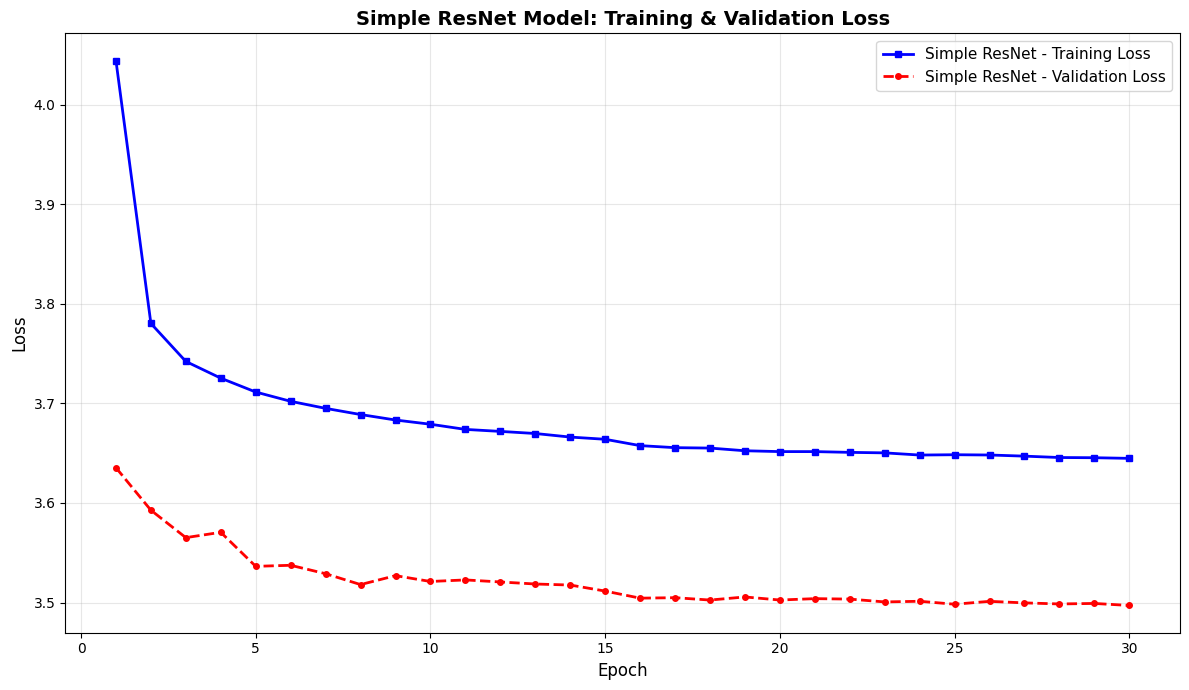


MODEL COMPARISON SUMMARY

Simple ResNet Baseline:
  Final Training Loss:   3.6448
  Final Validation Loss: 3.4971
  Best Validation Loss:  3.4971 at Epoch 30



In [ ]:
# Compare training curves: Complex vs Simple model
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(12, 7))

# Plot losses for the simple model
ax.plot(range(1, len(simple_history['loss_history']) + 1), 
    simple_history['loss_history'], 'r-', label='Simple ResNet - Training Loss', linewidth=2, marker='s', markersize=4, color='blue')
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    ax.plot(range(1, len(simple_history['val_loss_history']) + 1), 
        simple_history['val_loss_history'], 'r--', label='Simple ResNet - Validation Loss', linewidth=2, marker='o', markersize=4)

ax.set_xlabel('Epoch', fontsize=12)
ax.set_ylabel('Loss', fontsize=12)
ax.set_title('Simple ResNet Model: Training & Validation Loss', fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print comparison statistics
print("\n" + "=" * 80)
print("MODEL COMPARISON SUMMARY")
print("=" * 80)

print("\nSimple ResNet Baseline:")
print(f"  Final Training Loss:   {simple_history['loss_history'][-1]:.4f}")
if 'val_loss_history' in simple_history and simple_history['val_loss_history']:
    print(f"  Final Validation Loss: {simple_history['val_loss_history'][-1]:.4f}")
    best_val_loss = min(simple_history['val_loss_history'])
    best_epoch = simple_history['val_loss_history'].index(best_val_loss) + 1
    print(f"  Best Validation Loss:  {best_val_loss:.4f} at Epoch {best_epoch}")

print("\n" + "=" * 80)


## Evaluate Simple Model Embeddings

Let's evaluate the quality of embeddings from the simple ResNet model and compare clustering metrics.

In [ ]:
# test = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Extract embeddings from simple model
print("Extracting embeddings from simple ResNet model...")
simple_embeddings, simple_labels = extract_embeddings(simple_model, test_loader)
print(f"Extracted {len(simple_embeddings)} embeddings with dimension {simple_embeddings.shape[1]}")

# Calculate clustering metrics for simple model
simple_metrics = calculate_clustering_metrics(simple_embeddings, simple_labels)
print("\n" + "=" * 80)
print("SIMPLE RESNET MODEL - CLUSTERING METRICS")
print_clustering_metrics(simple_metrics)

Extracting embeddings from simple ResNet model...
Extracted 1561 embeddings with dimension 960

SIMPLE RESNET MODEL - CLUSTERING METRICS
CLUSTERING QUALITY METRICS
Number of samples: 1561
Number of classes: 21

Metrics:
  Silhouette Score:        -0.2032
    (Range: [-1, 1], Higher is better)
    > 0.5: Strong separation
    > 0.3: Reasonable separation

  Davies-Bouldin Score:    5.8723
    (Range: [0, ∞], Lower is better)
    < 1.0: Good clustering

  Calinski-Harabasz Score: 4.12
    (Range: [0, ∞], Higher is better)

Class Distribution:
  Class 14            :  913 samples ( 58.5%)
  Class 20            :  146 samples (  9.4%)
  Class 4             :  139 samples (  8.9%)
  Class 0             :   66 samples (  4.2%)
  Class 13            :   48 samples (  3.1%)
  Class 10            :   45 samples (  2.9%)
  Class 1             :   38 samples (  2.4%)
  Class 5             :   36 samples (  2.3%)
  Class 15            :   35 samples (  2.2%)
  Class 6             :   29 samples ( 


Generating t-SNE visualization for simple model...


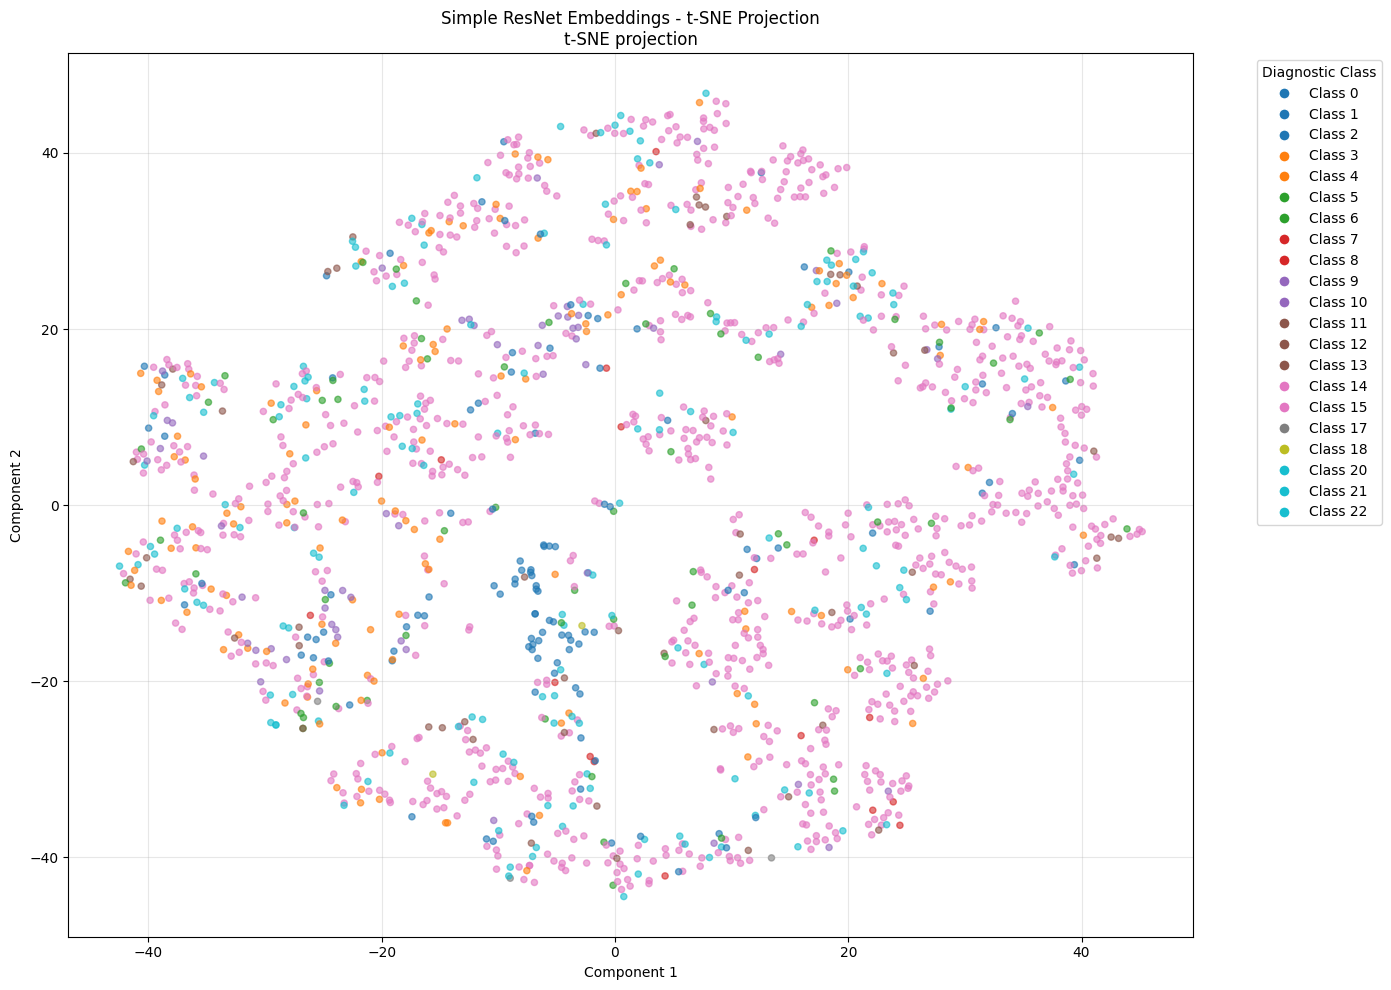

In [ ]:
# Visualize simple model embeddings with t-SNE
print("\nGenerating t-SNE visualization for simple model...")
simple_embeddings_2d_tsne, _ = plot_embeddings_2d(
    simple_embeddings, 
    simple_labels, 
    method='tsne', 
    title='Simple ResNet Embeddings - t-SNE Projection',
    figsize=(14, 10)
)

## Final Comparison & Analysis

Let's create a comprehensive comparison between the two models to identify what's working and what's not.

# Downstream classification

## Simple Classifier with Frozen Encoder

We'll use the pre-trained encoder as a frozen feature extractor and add a simple classification head on top. This allows us to evaluate the quality of the learned representations on downstream classification tasks.

In [ ]:
import torch

import torch.nn as nn

from torch.utils.data import DataLoader

from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report

from tqdm import tqdm


class SimpleClassifier(nn.Module):

    """

    Simple classifier that uses an encoder as backbone.



    Args:

        encoder: Pre-trained encoder model

        num_classes: Number of output classes

        hidden_dim: Hidden dimension for classification head (optional)

        encoder_dim: Output dimension of the encoder

        freeze_encoder: If True, freeze encoder weights; if False, allow joint training

    """

    def __init__(self, encoder, num_classes, hidden_dim=None, encoder_dim=1024, freeze_encoder=False):

        super().__init__()

        self.encoder = encoder

        self._apply_freeze_state(freeze_encoder)

        # Classification head

        if hidden_dim is not None:

            self.classifier = nn.Sequential(

                nn.Linear(encoder_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),

                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Dropout(0.3),
                
                nn.Linear(hidden_dim, num_classes),
                
                

            )

        else:

            self.classifier = nn.Linear(encoder_dim, num_classes)

    def _apply_freeze_state(self, freeze: bool) -> None:
        """Synchronize encoder grad state and mode with the requested freeze flag."""

        self.freeze_encoder = freeze

        for param in self.encoder.parameters():

            param.requires_grad = not freeze

        # train(mode=False) switches to eval; keeps BatchNorm/dropout consistent

        self.encoder.train(mode=not freeze)

    def forward(self, x):

        # Extract features (with or without gradients based on freeze_encoder)

        if self.freeze_encoder:

            with torch.no_grad():

                features, _ = self.encoder(x)

        else:

            features, _ = self.encoder(x)

        # Classify

        logits = self.classifier(features.to(x.dtype))

        return logits


def train_classifier(

    encoder,

    train_loader,

    val_loader,

    num_classes,

    hidden_dim=256,

    num_epochs=20,

    learning_rate=1e-3,

    device=None,

    patience=5,
    encoder_dim=1024,

    freeze_encoder=True,

    encoder_lr=1e-4

):
    """

    Train a classifier on top of an encoder.



    Args:

        encoder: Pre-trained encoder model

        train_loader: DataLoader for training data (with numerical labels)

        val_loader: DataLoader for validation data (with numerical labels)

        num_classes: Number of classes

        hidden_dim: Hidden dimension for classification head

        num_epochs: Maximum number of training epochs

        learning_rate: Learning rate for classifier head

        device: Device to train on

        patience: Early stopping patience

        freeze_encoder: If True, freeze encoder; if False, train encoder jointly

        encoder_lr: Learning rate for encoder (only used if freeze_encoder=False)



    Returns:

        model: Trained classifier

        history: Dictionary containing training history

    """

    if device is None:

        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Create model

    model = SimpleClassifier(encoder, num_classes, hidden_dim=hidden_dim, encoder_dim=encoder_dim,

                             freeze_encoder=freeze_encoder)

    model = model.to(device)

    # Loss function

    criterion = nn.CrossEntropyLoss()

    # Optimizer setup based on freeze_encoder flag

    if freeze_encoder:

        # Only optimize classifier parameters

        optimizer = torch.optim.Adam(
            model.classifier.parameters(), lr=learning_rate)

    else:

        # Optimize both encoder and classifier with different learning rates

        optimizer = torch.optim.Adam([

            {'params': model.encoder.parameters(), 'lr': encoder_lr},

            {'params': model.classifier.parameters(), 'lr': learning_rate}

        ])

    # Training history

    history = {

        'train_loss': [],

        'train_acc': [],

        'val_loss': [],

        'val_acc': [],

        'val_f1': []

    }

    best_val_acc = 0.0

    patience_counter = 0

    best_model_state = None

    # Print training configuration

    print(f"Training classifier on {device}")

    print(
        f"Training mode: {'Frozen encoder' if freeze_encoder else 'Joint training (encoder + classifier)'}")

    print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

    print(
        f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad):,}")

    print(
        f"Frozen parameters: {sum(p.numel() for p in model.parameters() if not p.requires_grad):,}")

    if not freeze_encoder:

        print(f"Encoder learning rate: {encoder_lr}")

        print(f"Classifier learning rate: {learning_rate}")

    else:

        print(f"Classifier learning rate: {learning_rate}")

    print()

    for epoch in range(num_epochs):

        # Training phase

        model.train()

        if freeze_encoder:

            model.encoder.eval()  # Keep encoder in eval mode when frozen

        train_loss = 0.0

        train_preds = []

        train_labels = []

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Train]')

        for signals, labels in pbar:

            signals, labels = signals.to(device), labels.to(device)

            # Forward pass

            optimizer.zero_grad()

            logits = model(signals)

            loss = criterion(logits, labels)

            # Backward pass

            loss.backward()

            optimizer.step()

            # Track metrics

            train_loss += loss.item() * signals.size(0)

            train_preds.extend(logits.argmax(dim=1).cpu().numpy())

            train_labels.extend(labels.cpu().numpy())

            pbar.set_postfix({'loss': loss.item()})

        # Calculate training metrics

        train_loss = train_loss / len(train_loader.dataset)

        train_acc = accuracy_score(train_labels, train_preds)

        # Validation phase

        model.eval()

        val_loss = 0.0

        val_preds = []

        val_labels = []

        with torch.no_grad():

            for signals, labels in tqdm(val_loader, desc=f'Epoch {epoch+1}/{num_epochs} [Val]  ', leave=False):

                signals, labels = signals.to(device), labels.to(device)

                logits = model(signals)

                loss = criterion(logits, labels)

                val_loss += loss.item() * signals.size(0)

                val_preds.extend(logits.argmax(dim=1).cpu().numpy())

                val_labels.extend(labels.cpu().numpy())

        # Calculate validation metrics

        val_loss = val_loss / len(val_loader.dataset)

        val_acc = accuracy_score(val_labels, val_preds)

        val_f1 = f1_score(val_labels, val_preds, average='weighted')

        # Store history

        history['train_loss'].append(train_loss)

        history['train_acc'].append(train_acc)

        history['val_loss'].append(val_loss)

        history['val_acc'].append(val_acc)

        history['val_f1'].append(val_f1)

        # Print epoch summary

        print(f'Epoch {epoch+1}/{num_epochs}:')

        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}')

        print(
            f'  Val Loss:   {val_loss:.4f}, Val Acc:   {val_acc:.4f}, Val F1: {val_f1:.4f}')

        # Early stopping

        if val_acc > best_val_acc:

            best_val_acc = val_acc

            patience_counter = 0

            best_model_state = model.state_dict().copy()

            print(f'  ✓ New best validation accuracy!')

        else:

            patience_counter += 1

            if patience_counter >= patience:

                print(f'\nEarly stopping triggered after {epoch+1} epochs')

                break

        print()

    # Load best model

    if best_model_state is not None:

        model.load_state_dict(best_model_state)

    return model, history


def evaluate_classifier(model, test_loader, idx_to_label=None, device=None):
    """

    Evaluate classifier on test set.



    Args:

        model: Trained classifier

        test_loader: DataLoader for test data

        idx_to_label: Optional mapping from indices to label names

        device: Device to run evaluation on



    Returns:

        metrics: Dictionary with evaluation metrics

    """

    if device is None:

        device = next(model.parameters()).device

    model.eval()

    all_preds = []

    all_labels = []

    with torch.no_grad():

        for signals, labels in tqdm(test_loader, desc='Evaluating'):

            signals, labels = signals.to(device), labels.to(device)

            logits = model(signals)

            preds = logits.argmax(dim=1)

            all_preds.extend(preds.cpu().numpy())

            all_labels.extend(labels.cpu().numpy())

    # Calculate metrics

    accuracy = accuracy_score(all_labels, all_preds)

    f1_weighted = f1_score(all_labels, all_preds, average='weighted')

    f1_macro = f1_score(all_labels, all_preds, average='macro')

    precision = precision_score(all_labels, all_preds, average='weighted')

    recall = recall_score(all_labels, all_preds, average='weighted')

    metrics = {

        'accuracy': accuracy,

        'f1_weighted': f1_weighted,

        'f1_macro': f1_macro,

        'precision': precision,

        'recall': recall,

        'predictions': all_preds,

        'labels': all_labels

    }

    # Print results

    print("=" * 60)

    print("TEST SET EVALUATION")

    print("=" * 60)

    print(f"Accuracy:          {accuracy:.4f}")

    print(f"F1 Score (weighted): {f1_weighted:.4f}")

    print(f"F1 Score (macro):    {f1_macro:.4f}")

    print(f"Precision:         {precision:.4f}")

    print(f"Recall:            {recall:.4f}")

    print("=" * 60)

    print()

    # Classification report

    if idx_to_label is not None:

        target_names = [idx_to_label[i] for i in sorted(idx_to_label.keys())]

    else:

        target_names = None

    print("CLASSIFICATION REPORT:")

    print(classification_report(all_labels, all_preds, target_names=target_names))

    return metrics

In [ ]:
# Train the classifier using the pre-trained encoder
train_dataset_classification = ECGDataset(
    X=X_train_filtered,
    y=Y_train_superclasses_dense,
)
test_dataset_classification = ECGDataset(
    X=X_test_filtered,
    y=Y_test_superclasses_dense,
)
train_loader_classification=DataLoader(train_dataset_classification, batch_size=128, shuffle=True)
val_loader_classification=DataLoader(test_dataset_classification, batch_size=128, shuffle=False)

classifier, training_history = train_classifier(
    encoder=simple_model,  # Your pre-trained encoder
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=20,
    encoder_dim=960,
    learning_rate=1e-3,
    patience=3000,
    freeze_encoder=True,  # Fine-tune the encoder as well
)

Training classifier on cuda
Training mode: Frozen encoder
Total parameters: 31,584,533
Trainable parameters: 378,885
Frozen parameters: 31,205,648
Classifier learning rate: 0.001



Epoch 1/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 35.01it/s, loss=1.01] 


Epoch 1/20:
  Train Loss: 1.0570, Train Acc: 0.6262
  Val Loss:   1.0217, Val Acc:   0.6291, Val F1: 0.5378
  ✓ New best validation accuracy!



Epoch 2/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 34.12it/s, loss=0.975]


Epoch 2/20:
  Train Loss: 0.9986, Train Acc: 0.6473
  Val Loss:   1.0349, Val Acc:   0.6188, Val F1: 0.5330



Epoch 3/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 34.61it/s, loss=0.955]


Epoch 3/20:
  Train Loss: 0.9827, Train Acc: 0.6515
  Val Loss:   1.0360, Val Acc:   0.6310, Val F1: 0.5447
  ✓ New best validation accuracy!



Epoch 4/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 34.62it/s, loss=1.05] 


Epoch 4/20:
  Train Loss: 0.9865, Train Acc: 0.6511
  Val Loss:   1.0346, Val Acc:   0.6291, Val F1: 0.5497



Epoch 5/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 35.63it/s, loss=0.837]


Epoch 5/20:
  Train Loss: 0.9796, Train Acc: 0.6512
  Val Loss:   1.0336, Val Acc:   0.6259, Val F1: 0.5383



Epoch 6/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 33.93it/s, loss=1.17] 


Epoch 6/20:
  Train Loss: 0.9700, Train Acc: 0.6545
  Val Loss:   1.0294, Val Acc:   0.6291, Val F1: 0.5434



Epoch 7/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 33.76it/s, loss=0.836]


Epoch 7/20:
  Train Loss: 0.9692, Train Acc: 0.6540
  Val Loss:   1.0244, Val Acc:   0.6252, Val F1: 0.5452



Epoch 8/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 33.69it/s, loss=1.01] 


Epoch 8/20:
  Train Loss: 0.9683, Train Acc: 0.6538
  Val Loss:   1.0186, Val Acc:   0.6329, Val F1: 0.5455
  ✓ New best validation accuracy!



Epoch 9/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 31.99it/s, loss=0.996]


Epoch 9/20:
  Train Loss: 0.9610, Train Acc: 0.6533
  Val Loss:   1.0213, Val Acc:   0.6284, Val F1: 0.5457



Epoch 10/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.55it/s, loss=0.967]


Epoch 10/20:
  Train Loss: 0.9641, Train Acc: 0.6548
  Val Loss:   1.0268, Val Acc:   0.6316, Val F1: 0.5534



Epoch 11/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.51it/s, loss=0.814]


Epoch 11/20:
  Train Loss: 0.9568, Train Acc: 0.6560
  Val Loss:   1.0161, Val Acc:   0.6297, Val F1: 0.5512



Epoch 12/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.62it/s, loss=1.11] 


Epoch 12/20:
  Train Loss: 0.9544, Train Acc: 0.6578
  Val Loss:   1.0278, Val Acc:   0.6329, Val F1: 0.5602



Epoch 13/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.66it/s, loss=0.923]


Epoch 13/20:
  Train Loss: 0.9547, Train Acc: 0.6579
  Val Loss:   1.0184, Val Acc:   0.6316, Val F1: 0.5471



Epoch 14/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 31.80it/s, loss=1.08] 


Epoch 14/20:
  Train Loss: 0.9527, Train Acc: 0.6581
  Val Loss:   1.0317, Val Acc:   0.6342, Val F1: 0.5556
  ✓ New best validation accuracy!



Epoch 15/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.59it/s, loss=1.06] 


Epoch 15/20:
  Train Loss: 0.9485, Train Acc: 0.6610
  Val Loss:   1.0242, Val Acc:   0.6323, Val F1: 0.5454



Epoch 16/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.59it/s, loss=1.09] 


Epoch 16/20:
  Train Loss: 0.9497, Train Acc: 0.6566
  Val Loss:   1.0112, Val Acc:   0.6316, Val F1: 0.5436



Epoch 17/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.60it/s, loss=0.905]


Epoch 17/20:
  Train Loss: 0.9484, Train Acc: 0.6571
  Val Loss:   1.0200, Val Acc:   0.6381, Val F1: 0.5720
  ✓ New best validation accuracy!



Epoch 18/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 31.92it/s, loss=0.905]


Epoch 18/20:
  Train Loss: 0.9459, Train Acc: 0.6584
  Val Loss:   1.0155, Val Acc:   0.6374, Val F1: 0.5573



Epoch 19/20 [Train]: 100%|██████████| 95/95 [00:02<00:00, 31.88it/s, loss=0.937]


Epoch 19/20:
  Train Loss: 0.9405, Train Acc: 0.6612
  Val Loss:   1.0185, Val Acc:   0.6304, Val F1: 0.5521



Epoch 20/20 [Train]: 100%|██████████| 95/95 [00:03<00:00, 31.32it/s, loss=0.974]
                                                                    

Epoch 20/20:
  Train Loss: 0.9414, Train Acc: 0.6615
  Val Loss:   1.0348, Val Acc:   0.6284, Val F1: 0.5730



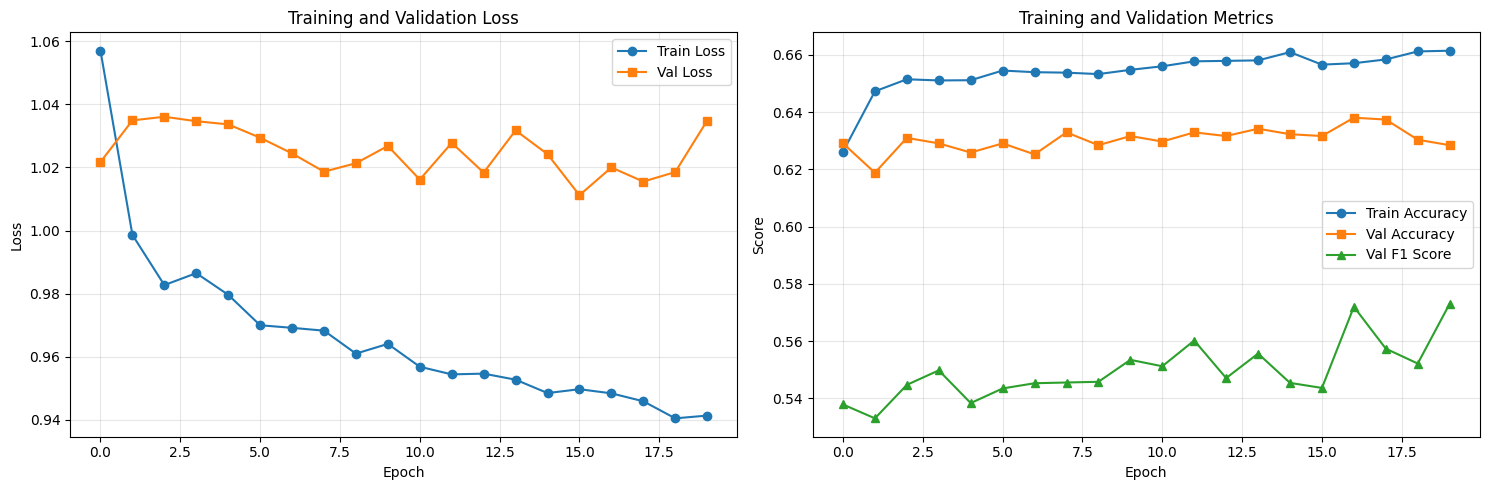


Best Training Accuracy: 0.6615
Best Validation Accuracy: 0.6381
Best Validation F1: 0.5730


In [ ]:
# Plot training history
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Loss plot
axes[0].plot(training_history['train_loss'], label='Train Loss', marker='o')
axes[0].plot(training_history['val_loss'], label='Val Loss', marker='s')
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training and Validation Loss')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy plot
axes[1].plot(training_history['train_acc'], label='Train Accuracy', marker='o')
axes[1].plot(training_history['val_acc'], label='Val Accuracy', marker='s')
axes[1].plot(training_history['val_f1'], label='Val F1 Score', marker='^')
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Score')
axes[1].set_title('Training and Validation Metrics')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print best results
print(f"\nBest Training Accuracy: {max(training_history['train_acc']):.4f}")
print(f"Best Validation Accuracy: {max(training_history['val_acc']):.4f}")
print(f"Best Validation F1: {max(training_history['val_f1']):.4f}")

In [ ]:
# Evaluate on test set
Y_test_superclasses_dense = Y_test_superclasses.argmax(axis=1)
test_dataset_classification = ECGDataset(
    X=X_test_filtered,
    y=Y_test_superclasses_dense,
)
test_loader_classification = DataLoader(test_dataset_classification, batch_size=128, shuffle=False)
test_metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification,
    idx_to_label={
                  
                  0: 'Normal',
                  1: 'Myocardial Infarction',
                  2: 'ST/T Change',
                  3: 'HYP (Hypertrophy)',
                  4: 'CD (Conduction Disturbance)',
    }
)

Evaluating:   0%|          | 0/13 [00:00<?, ?it/s]

Evaluating: 100%|██████████| 13/13 [00:00<00:00, 35.32it/s]

TEST SET EVALUATION
Accuracy:          0.6284
F1 Score (weighted): 0.5730
F1 Score (macro):    0.3643
Precision:         0.5748
Recall:            0.6284

CLASSIFICATION REPORT:
                             precision    recall  f1-score   support

                     Normal       0.69      0.90      0.78       913
      Myocardial Infarction       0.40      0.04      0.07       208
                ST/T Change       0.38      0.29      0.33       227
          HYP (Hypertrophy)       0.14      0.09      0.11        54
CD (Conduction Disturbance)       0.55      0.51      0.53       159

                   accuracy                           0.63      1561
                  macro avg       0.43      0.37      0.36      1561
               weighted avg       0.57      0.63      0.57      1561



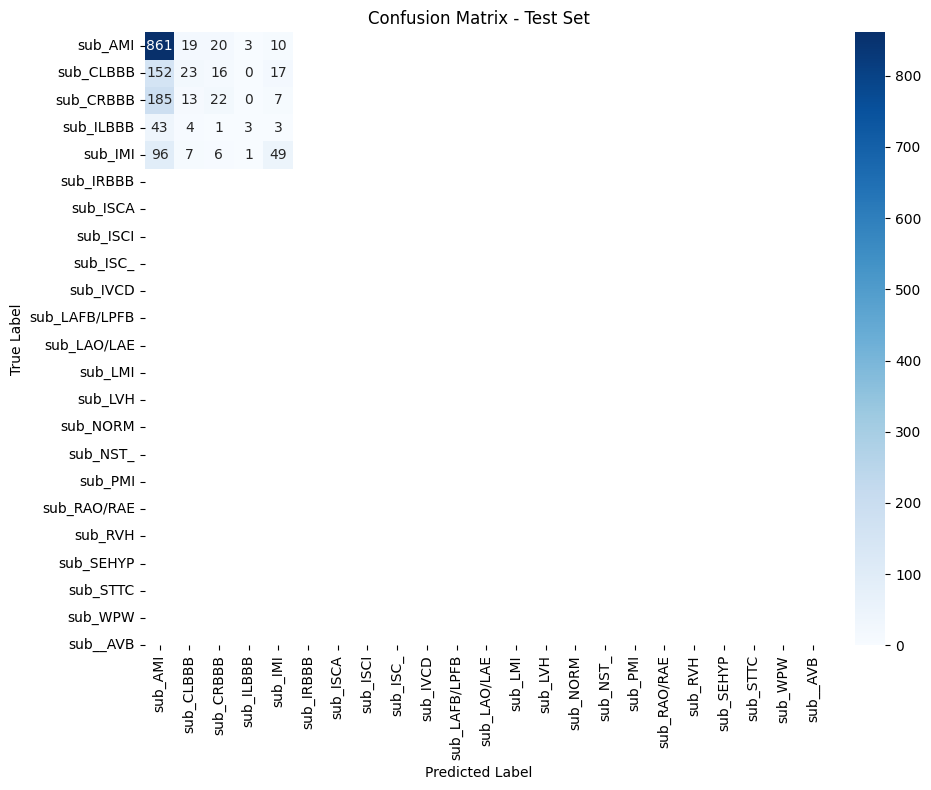


Per-Class Accuracy:
  sub_AMI             : 0.9430 (861/913)
  sub_CLBBB           : 0.1106 (23/208)
  sub_CRBBB           : 0.0969 (22/227)
  sub_ILBBB           : 0.0556 (3/54)
  sub_IMI             : 0.3082 (49/159)


IndexError: index 5 is out of bounds for axis 0 with size 5

In [ ]:
# Plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(test_metrics['labels'], test_metrics['predictions'])
class_names = [idx_to_label[i] for i in range(len(idx_to_label))]

plt.figure(figsize=(10, 8))
sns.heatmap(
    cm, 
    annot=True, 
    fmt='d', 
    cmap='Blues',
    xticklabels=class_names,
    yticklabels=class_names
)
plt.title('Confusion Matrix - Test Set')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

# Per-class accuracy
print("\nPer-Class Accuracy:")
for i, class_name in enumerate(class_names):
    class_acc = cm[i, i] / cm[i].sum() if cm[i].sum() > 0 else 0
    print(f"  {class_name:20s}: {class_acc:.4f} ({cm[i, i]}/{cm[i].sum()})")

### Understanding the Results

The classifier evaluation provides insights into how well the pre-trained encoder's representations transfer to the downstream classification task:

**Key Metrics:**
- **Accuracy**: Overall percentage of correct predictions
- **F1 Score (Weighted)**: Harmonic mean of precision and recall, weighted by class support
- **F1 Score (Macro)**: Average F1 across all classes (treats all classes equally)
- **Precision**: Percentage of positive predictions that are correct
- **Recall**: Percentage of actual positives that are identified

**Interpreting Performance:**
- High test accuracy indicates good representation learning
- Compare with training from scratch to quantify the benefit of pre-training
- Per-class metrics reveal which diagnostic classes are easier/harder to classify
- Confusion matrix shows common misclassification patterns

**Architecture Notes:**
- The encoder is **frozen** (not updated during training)
- Only the classification head learns during training
- This tests the quality of the learned representations for downstream tasks

### Optional: Baseline Comparison

To validate that the pre-trained encoder learned useful representations, you can compare against a randomly initialized encoder:

In [ ]:
# Optional: Train classifier with random encoder (baseline)
# This helps quantify the benefit of pre-training

# Create a new random encoder with the same architecture
random_encoder = ECGEncoder(
    input_channels=12,
    d_model=512,
    nhead=8,
    num_layers=6,
    dim_feedforward=2048,
    dropout=0.1
).to(torch.device('cuda' if torch.cuda.is_available() else 'cpu'))

# Train classifier on random features
print("Training classifier with RANDOM encoder (baseline)...")
baseline_classifier, baseline_history = train_classifier(
    encoder=random_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=test_dataset_classification.num_classes,
    hidden_dim=256,
    num_epochs=30,
    learning_rate=1e-3,
    patience=5
)

# Evaluate baseline
print("\n" + "="*60)
print("BASELINE EVALUATION (Random Encoder)")
print("="*60)
baseline_metrics = evaluate_classifier(
    model=baseline_classifier,
    test_loader=test_loader_classification,
    idx_to_label=idx_to_label
)

# Compare results
print("\n" + "="*60)
print("COMPARISON: Pre-trained vs Random Encoder")
print("="*60)
print(f"Pre-trained Encoder Test Accuracy: {test_metrics['accuracy']:.4f}")
print(f"Random Encoder Test Accuracy:      {baseline_metrics['accuracy']:.4f}")
print(f"Improvement:                        {(test_metrics['accuracy'] - baseline_metrics['accuracy']):.4f}")
print(f"Relative Improvement:               {((test_metrics['accuracy'] - baseline_metrics['accuracy']) / baseline_metrics['accuracy'] * 100):.2f}%")
print("="*60)

---

## Summary: Downstream Classification Workflow

This section evaluates the quality of the learned encoder representations using a simple downstream classification task. Here's the complete workflow:

### 1. **Data Preparation**
   - Created datasets with numerical labels using `ECGDataset(map_labels_to_int=True)`
   - Split into train/val/test sets with proper DataLoaders

### 2. **Model Architecture**
   - `SimpleClassifier`: Frozen encoder + trainable classification head
   - Only the classification head parameters are updated during training
   - This isolates the evaluation to the encoder's representation quality

### 3. **Training**
   - Uses `train_classifier()` function that accepts any encoder
   - Early stopping based on validation accuracy
   - Tracks loss, accuracy, and F1 score
   - Returns trained model and training history

### 4. **Evaluation**
   - Comprehensive metrics: accuracy, F1 (weighted & macro), precision, recall
   - Classification report per class
   - Confusion matrix visualization
   - Per-class accuracy breakdown

### 5. **Baseline Comparison (Optional)**
   - Compare against randomly initialized encoder
   - Quantifies the benefit of contrastive pre-training
   - Shows relative improvement from learned representations

### Usage Example:
```python
# Train classifier
classifier, history = train_classifier(
    encoder=your_pretrained_encoder,
    train_loader=train_loader_classification,
    val_loader=val_loader_classification,
    num_classes=num_classes
)

# Evaluate
metrics = evaluate_classifier(
    model=classifier,
    test_loader=test_loader_classification
)
```

This approach is a standard method for evaluating self-supervised learning models on downstream tasks.

# Visualizing Attention

### Design choices for the plots
- Random training batch to surface diverse morphologies
- Last encoder layer only; head-averaged weights
- Raw attention values (no normalization) with fixed percentile-based color scale
- Immediate plotting so each run reflects the freshly sampled batch

In [15]:
from collections.abc import Mapping
from typing import Dict, Tuple

import matplotlib.pyplot as plt
import numpy as np
import torch

from src.our_model import collect_head_averaged_attention

ATTN_PERCENTILES: Tuple[int, int] = (5, 95)


def sample_random_training_batch(loader, device: torch.device) -> torch.Tensor:
    """Return a single randomly ordered batch from the shuffled training loader."""
    if loader is None:
        raise ValueError("train_loader_classification must be initialized before sampling.")
    batch_signals, _ = next(iter(loader))  # shuffle=True on the loader keeps this diverse
    return batch_signals.to(device)


def run_encoder_and_collect_attention(
    encoder: torch.nn.Module, signals: torch.Tensor
) -> Dict[str, torch.Tensor]:
    encoder.eval()
    with torch.no_grad():
        _ = encoder(signals)
    maps = collect_head_averaged_attention(encoder)
    if not maps:
        raise RuntimeError("No attention maps were captured; ensure the forward pass ran.")
    return maps


def compute_percentile_limits(
    data: Mapping[str, np.ndarray] | np.ndarray, percentiles: Tuple[int, int]
) -> Tuple[float, float]:
    """Compute percentile-based limits for either a dict of matrices or a single matrix."""
    if isinstance(data, Mapping):
        pooled = np.concatenate([matrix.reshape(-1) for matrix in data.values() if matrix.size > 0])
    else:
        matrix = np.asarray(data)
        pooled = matrix.reshape(-1)
    vmin = float(np.percentile(pooled, percentiles[0]))
    vmax = float(np.percentile(pooled, percentiles[1]))
    if np.isclose(vmin, vmax):
        vmax = vmin + 1e-6  # avoid a degenerate color scale
    return vmin, vmax


def pick_sample_maps(
    maps: Dict[str, torch.Tensor], sample_idx: int
) -> Dict[str, np.ndarray]:
    return {
        name: tensor[sample_idx].to(torch.float32).detach().cpu().numpy()
        for name, tensor in maps.items()
        if tensor is not None
    }


def summarize_attention_matrix(matrix: np.ndarray) -> Dict[str, float]:
    row_sums = matrix.sum(axis=-1)
    col_sums = matrix.sum(axis=-2)
    return {
        "mean": float(matrix.mean()),
        "std": float(matrix.std()),
        "min": float(matrix.min()),
        "max": float(matrix.max()),
        "row_sum_mean": float(row_sums.mean()),
        "row_sum_std": float(row_sums.std()),
        "col_sum_mean": float(col_sums.mean()),
        "col_sum_std": float(col_sums.std()),
    }


def summarize_attention_maps(maps: Dict[str, np.ndarray]) -> Dict[str, Dict[str, float]]:
    return {name: summarize_attention_matrix(matrix) for name, matrix in maps.items()}


def plot_attention_matrix(
    ax: plt.Axes,
    matrix: np.ndarray,
    title: str,
    xlabel: str,
    ylabel: str,
    vmin: float,
    vmax: float,
) -> plt.Axes:
    image = ax.imshow(
        matrix,
        cmap="magma",
        vmin=vmin,
        vmax=vmax,
        origin="lower",
        aspect="auto",
    )
    ax.set_title(title, fontsize=11)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    return image

In [31]:
from pathlib import Path

checkpoint_path = Path("/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/models/checkpoints/checkpoint_epoch_70.pt")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

raw_ckpt = torch.load(checkpoint_path, map_location=device)
state_dict = raw_ckpt.get("model_state_dict") or raw_ckpt.get("state_dict") or raw_ckpt
ecg_encoder.to(device)
ecg_encoder.load_state_dict(state_dict)
ecg_encoder.eval()
print(f"Loaded ECG encoder weights from {checkpoint_path}")

RuntimeError: Error(s) in loading state_dict for ECGEncoder:
	Missing key(s) in state_dict: "time_conv_embedding.net.0.weight", "time_conv_embedding.net.2.weight", "time_conv_embedding.net.2.bias", "time_conv_embedding.proj.weight", "time_conv_embedding.proj.bias", "time_conv_embedding.norm.weight", "time_conv_embedding.norm.bias", "time_positional_encoding.embedding", "time_transformer.encoder.layers.0.self_attn.in_proj_weight", "time_transformer.encoder.layers.0.self_attn.in_proj_bias", "time_transformer.encoder.layers.0.self_attn.out_proj.weight", "time_transformer.encoder.layers.0.self_attn.out_proj.bias", "time_transformer.encoder.layers.0.linear1.weight", "time_transformer.encoder.layers.0.linear1.bias", "time_transformer.encoder.layers.0.linear2.weight", "time_transformer.encoder.layers.0.linear2.bias", "time_transformer.encoder.layers.0.norm1.weight", "time_transformer.encoder.layers.0.norm1.bias", "time_transformer.encoder.layers.0.norm2.weight", "time_transformer.encoder.layers.0.norm2.bias", "time_transformer.encoder.layers.1.self_attn.in_proj_weight", "time_transformer.encoder.layers.1.self_attn.in_proj_bias", "time_transformer.encoder.layers.1.self_attn.out_proj.weight", "time_transformer.encoder.layers.1.self_attn.out_proj.bias", "time_transformer.encoder.layers.1.linear1.weight", "time_transformer.encoder.layers.1.linear1.bias", "time_transformer.encoder.layers.1.linear2.weight", "time_transformer.encoder.layers.1.linear2.bias", "time_transformer.encoder.layers.1.norm1.weight", "time_transformer.encoder.layers.1.norm1.bias", "time_transformer.encoder.layers.1.norm2.weight", "time_transformer.encoder.layers.1.norm2.bias", "time_transformer.encoder.layers.2.self_attn.in_proj_weight", "time_transformer.encoder.layers.2.self_attn.in_proj_bias", "time_transformer.encoder.layers.2.self_attn.out_proj.weight", "time_transformer.encoder.layers.2.self_attn.out_proj.bias", "time_transformer.encoder.layers.2.linear1.weight", "time_transformer.encoder.layers.2.linear1.bias", "time_transformer.encoder.layers.2.linear2.weight", "time_transformer.encoder.layers.2.linear2.bias", "time_transformer.encoder.layers.2.norm1.weight", "time_transformer.encoder.layers.2.norm1.bias", "time_transformer.encoder.layers.2.norm2.weight", "time_transformer.encoder.layers.2.norm2.bias", "time_transformer.encoder.layers.3.self_attn.in_proj_weight", "time_transformer.encoder.layers.3.self_attn.in_proj_bias", "time_transformer.encoder.layers.3.self_attn.out_proj.weight", "time_transformer.encoder.layers.3.self_attn.out_proj.bias", "time_transformer.encoder.layers.3.linear1.weight", "time_transformer.encoder.layers.3.linear1.bias", "time_transformer.encoder.layers.3.linear2.weight", "time_transformer.encoder.layers.3.linear2.bias", "time_transformer.encoder.layers.3.norm1.weight", "time_transformer.encoder.layers.3.norm1.bias", "time_transformer.encoder.layers.3.norm2.weight", "time_transformer.encoder.layers.3.norm2.bias", "time_transformer.encoder.layers.4.self_attn.in_proj_weight", "time_transformer.encoder.layers.4.self_attn.in_proj_bias", "time_transformer.encoder.layers.4.self_attn.out_proj.weight", "time_transformer.encoder.layers.4.self_attn.out_proj.bias", "time_transformer.encoder.layers.4.linear1.weight", "time_transformer.encoder.layers.4.linear1.bias", "time_transformer.encoder.layers.4.linear2.weight", "time_transformer.encoder.layers.4.linear2.bias", "time_transformer.encoder.layers.4.norm1.weight", "time_transformer.encoder.layers.4.norm1.bias", "time_transformer.encoder.layers.4.norm2.weight", "time_transformer.encoder.layers.4.norm2.bias", "time_transformer.encoder.layers.5.self_attn.in_proj_weight", "time_transformer.encoder.layers.5.self_attn.in_proj_bias", "time_transformer.encoder.layers.5.self_attn.out_proj.weight", "time_transformer.encoder.layers.5.self_attn.out_proj.bias", "time_transformer.encoder.layers.5.linear1.weight", "time_transformer.encoder.layers.5.linear1.bias", "time_transformer.encoder.layers.5.linear2.weight", "time_transformer.encoder.layers.5.linear2.bias", "time_transformer.encoder.layers.5.norm1.weight", "time_transformer.encoder.layers.5.norm1.bias", "time_transformer.encoder.layers.5.norm2.weight", "time_transformer.encoder.layers.5.norm2.bias", "channel_conv_embedding.net.0.weight", "channel_conv_embedding.net.2.weight", "channel_conv_embedding.net.2.bias", "channel_conv_embedding.net.4.weight", "channel_conv_embedding.net.6.weight", "channel_conv_embedding.net.6.bias", "channel_conv_embedding.channel_proj.weight", "channel_conv_embedding.channel_proj.bias", "channel_norm.weight", "channel_norm.bias", "channel_transformer.encoder.layers.0.self_attn.in_proj_weight", "channel_transformer.encoder.layers.0.self_attn.in_proj_bias", "channel_transformer.encoder.layers.0.self_attn.out_proj.weight", "channel_transformer.encoder.layers.0.self_attn.out_proj.bias", "channel_transformer.encoder.layers.0.linear1.weight", "channel_transformer.encoder.layers.0.linear1.bias", "channel_transformer.encoder.layers.0.linear2.weight", "channel_transformer.encoder.layers.0.linear2.bias", "channel_transformer.encoder.layers.0.norm1.weight", "channel_transformer.encoder.layers.0.norm1.bias", "channel_transformer.encoder.layers.0.norm2.weight", "channel_transformer.encoder.layers.0.norm2.bias", "channel_transformer.encoder.layers.1.self_attn.in_proj_weight", "channel_transformer.encoder.layers.1.self_attn.in_proj_bias", "channel_transformer.encoder.layers.1.self_attn.out_proj.weight", "channel_transformer.encoder.layers.1.self_attn.out_proj.bias", "channel_transformer.encoder.layers.1.linear1.weight", "channel_transformer.encoder.layers.1.linear1.bias", "channel_transformer.encoder.layers.1.linear2.weight", "channel_transformer.encoder.layers.1.linear2.bias", "channel_transformer.encoder.layers.1.norm1.weight", "channel_transformer.encoder.layers.1.norm1.bias", "channel_transformer.encoder.layers.1.norm2.weight", "channel_transformer.encoder.layers.1.norm2.bias", "channel_transformer.encoder.layers.2.self_attn.in_proj_weight", "channel_transformer.encoder.layers.2.self_attn.in_proj_bias", "channel_transformer.encoder.layers.2.self_attn.out_proj.weight", "channel_transformer.encoder.layers.2.self_attn.out_proj.bias", "channel_transformer.encoder.layers.2.linear1.weight", "channel_transformer.encoder.layers.2.linear1.bias", "channel_transformer.encoder.layers.2.linear2.weight", "channel_transformer.encoder.layers.2.linear2.bias", "channel_transformer.encoder.layers.2.norm1.weight", "channel_transformer.encoder.layers.2.norm1.bias", "channel_transformer.encoder.layers.2.norm2.weight", "channel_transformer.encoder.layers.2.norm2.bias", "channel_transformer.encoder.layers.3.self_attn.in_proj_weight", "channel_transformer.encoder.layers.3.self_attn.in_proj_bias", "channel_transformer.encoder.layers.3.self_attn.out_proj.weight", "channel_transformer.encoder.layers.3.self_attn.out_proj.bias", "channel_transformer.encoder.layers.3.linear1.weight", "channel_transformer.encoder.layers.3.linear1.bias", "channel_transformer.encoder.layers.3.linear2.weight", "channel_transformer.encoder.layers.3.linear2.bias", "channel_transformer.encoder.layers.3.norm1.weight", "channel_transformer.encoder.layers.3.norm1.bias", "channel_transformer.encoder.layers.3.norm2.weight", "channel_transformer.encoder.layers.3.norm2.bias", "channel_transformer.encoder.layers.4.self_attn.in_proj_weight", "channel_transformer.encoder.layers.4.self_attn.in_proj_bias", "channel_transformer.encoder.layers.4.self_attn.out_proj.weight", "channel_transformer.encoder.layers.4.self_attn.out_proj.bias", "channel_transformer.encoder.layers.4.linear1.weight", "channel_transformer.encoder.layers.4.linear1.bias", "channel_transformer.encoder.layers.4.linear2.weight", "channel_transformer.encoder.layers.4.linear2.bias", "channel_transformer.encoder.layers.4.norm1.weight", "channel_transformer.encoder.layers.4.norm1.bias", "channel_transformer.encoder.layers.4.norm2.weight", "channel_transformer.encoder.layers.4.norm2.bias", "channel_transformer.encoder.layers.5.self_attn.in_proj_weight", "channel_transformer.encoder.layers.5.self_attn.in_proj_bias", "channel_transformer.encoder.layers.5.self_attn.out_proj.weight", "channel_transformer.encoder.layers.5.self_attn.out_proj.bias", "channel_transformer.encoder.layers.5.linear1.weight", "channel_transformer.encoder.layers.5.linear1.bias", "channel_transformer.encoder.layers.5.linear2.weight", "channel_transformer.encoder.layers.5.linear2.bias", "channel_transformer.encoder.layers.5.norm1.weight", "channel_transformer.encoder.layers.5.norm1.bias", "channel_transformer.encoder.layers.5.norm2.weight", "channel_transformer.encoder.layers.5.norm2.bias", "fusion.linear_in.weight", "fusion.linear_in.bias", "fusion.norm_in.weight", "fusion.norm_in.bias", "fusion.linear_out.weight", "fusion.linear_out.bias", "fusion.norm_out.weight", "fusion.norm_out.bias". 
	Unexpected key(s) in state_dict: "time_encoder.input_proj.weight", "time_encoder.input_proj.bias", "time_encoder.encoder.layers.0.self_attn.in_proj_weight", "time_encoder.encoder.layers.0.self_attn.in_proj_bias", "time_encoder.encoder.layers.0.self_attn.out_proj.weight", "time_encoder.encoder.layers.0.self_attn.out_proj.bias", "time_encoder.encoder.layers.0.linear1.weight", "time_encoder.encoder.layers.0.linear1.bias", "time_encoder.encoder.layers.0.linear2.weight", "time_encoder.encoder.layers.0.linear2.bias", "time_encoder.encoder.layers.0.norm1.weight", "time_encoder.encoder.layers.0.norm1.bias", "time_encoder.encoder.layers.0.norm2.weight", "time_encoder.encoder.layers.0.norm2.bias", "time_encoder.encoder.layers.1.self_attn.in_proj_weight", "time_encoder.encoder.layers.1.self_attn.in_proj_bias", "time_encoder.encoder.layers.1.self_attn.out_proj.weight", "time_encoder.encoder.layers.1.self_attn.out_proj.bias", "time_encoder.encoder.layers.1.linear1.weight", "time_encoder.encoder.layers.1.linear1.bias", "time_encoder.encoder.layers.1.linear2.weight", "time_encoder.encoder.layers.1.linear2.bias", "time_encoder.encoder.layers.1.norm1.weight", "time_encoder.encoder.layers.1.norm1.bias", "time_encoder.encoder.layers.1.norm2.weight", "time_encoder.encoder.layers.1.norm2.bias", "time_encoder.encoder.layers.2.self_attn.in_proj_weight", "time_encoder.encoder.layers.2.self_attn.in_proj_bias", "time_encoder.encoder.layers.2.self_attn.out_proj.weight", "time_encoder.encoder.layers.2.self_attn.out_proj.bias", "time_encoder.encoder.layers.2.linear1.weight", "time_encoder.encoder.layers.2.linear1.bias", "time_encoder.encoder.layers.2.linear2.weight", "time_encoder.encoder.layers.2.linear2.bias", "time_encoder.encoder.layers.2.norm1.weight", "time_encoder.encoder.layers.2.norm1.bias", "time_encoder.encoder.layers.2.norm2.weight", "time_encoder.encoder.layers.2.norm2.bias", "time_encoder.encoder.layers.3.self_attn.in_proj_weight", "time_encoder.encoder.layers.3.self_attn.in_proj_bias", "time_encoder.encoder.layers.3.self_attn.out_proj.weight", "time_encoder.encoder.layers.3.self_attn.out_proj.bias", "time_encoder.encoder.layers.3.linear1.weight", "time_encoder.encoder.layers.3.linear1.bias", "time_encoder.encoder.layers.3.linear2.weight", "time_encoder.encoder.layers.3.linear2.bias", "time_encoder.encoder.layers.3.norm1.weight", "time_encoder.encoder.layers.3.norm1.bias", "time_encoder.encoder.layers.3.norm2.weight", "time_encoder.encoder.layers.3.norm2.bias", "time_encoder.positional_encoding.embedding", "channel_encoder.downsample.0.weight", "channel_encoder.downsample.2.weight", "channel_encoder.downsample.2.bias", "channel_encoder.downsample.4.weight", "channel_encoder.downsample.6.weight", "channel_encoder.downsample.6.bias", "channel_encoder.channel_proj.weight", "channel_encoder.channel_proj.bias", "channel_encoder.pre_encoder_norm.weight", "channel_encoder.pre_encoder_norm.bias", "channel_encoder.encoder.layers.0.self_attn.in_proj_weight", "channel_encoder.encoder.layers.0.self_attn.in_proj_bias", "channel_encoder.encoder.layers.0.self_attn.out_proj.weight", "channel_encoder.encoder.layers.0.self_attn.out_proj.bias", "channel_encoder.encoder.layers.0.linear1.weight", "channel_encoder.encoder.layers.0.linear1.bias", "channel_encoder.encoder.layers.0.linear2.weight", "channel_encoder.encoder.layers.0.linear2.bias", "channel_encoder.encoder.layers.0.norm1.weight", "channel_encoder.encoder.layers.0.norm1.bias", "channel_encoder.encoder.layers.0.norm2.weight", "channel_encoder.encoder.layers.0.norm2.bias", "channel_encoder.encoder.layers.1.self_attn.in_proj_weight", "channel_encoder.encoder.layers.1.self_attn.in_proj_bias", "channel_encoder.encoder.layers.1.self_attn.out_proj.weight", "channel_encoder.encoder.layers.1.self_attn.out_proj.bias", "channel_encoder.encoder.layers.1.linear1.weight", "channel_encoder.encoder.layers.1.linear1.bias", "channel_encoder.encoder.layers.1.linear2.weight", "channel_encoder.encoder.layers.1.linear2.bias", "channel_encoder.encoder.layers.1.norm1.weight", "channel_encoder.encoder.layers.1.norm1.bias", "channel_encoder.encoder.layers.1.norm2.weight", "channel_encoder.encoder.layers.1.norm2.bias", "channel_encoder.encoder.layers.2.self_attn.in_proj_weight", "channel_encoder.encoder.layers.2.self_attn.in_proj_bias", "channel_encoder.encoder.layers.2.self_attn.out_proj.weight", "channel_encoder.encoder.layers.2.self_attn.out_proj.bias", "channel_encoder.encoder.layers.2.linear1.weight", "channel_encoder.encoder.layers.2.linear1.bias", "channel_encoder.encoder.layers.2.linear2.weight", "channel_encoder.encoder.layers.2.linear2.bias", "channel_encoder.encoder.layers.2.norm1.weight", "channel_encoder.encoder.layers.2.norm1.bias", "channel_encoder.encoder.layers.2.norm2.weight", "channel_encoder.encoder.layers.2.norm2.bias", "channel_encoder.encoder.layers.3.self_attn.in_proj_weight", "channel_encoder.encoder.layers.3.self_attn.in_proj_bias", "channel_encoder.encoder.layers.3.self_attn.out_proj.weight", "channel_encoder.encoder.layers.3.self_attn.out_proj.bias", "channel_encoder.encoder.layers.3.linear1.weight", "channel_encoder.encoder.layers.3.linear1.bias", "channel_encoder.encoder.layers.3.linear2.weight", "channel_encoder.encoder.layers.3.linear2.bias", "channel_encoder.encoder.layers.3.norm1.weight", "channel_encoder.encoder.layers.3.norm1.bias", "channel_encoder.encoder.layers.3.norm2.weight", "channel_encoder.encoder.layers.3.norm2.bias", "fusion.linear.weight", "fusion.linear.bias", "fusion.norm.weight", "fusion.norm.bias". 
	size mismatch for cross_attention.time_to_channel.in_proj_weight: copying a param with shape torch.Size([3072, 1024]) from checkpoint, the shape in current model is torch.Size([1860, 620]).
	size mismatch for cross_attention.time_to_channel.in_proj_bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1860]).
	size mismatch for cross_attention.time_to_channel.out_proj.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([620, 620]).
	size mismatch for cross_attention.time_to_channel.out_proj.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for cross_attention.channel_to_time.in_proj_weight: copying a param with shape torch.Size([3072, 1024]) from checkpoint, the shape in current model is torch.Size([1860, 620]).
	size mismatch for cross_attention.channel_to_time.in_proj_bias: copying a param with shape torch.Size([3072]) from checkpoint, the shape in current model is torch.Size([1860]).
	size mismatch for cross_attention.channel_to_time.out_proj.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([620, 620]).
	size mismatch for cross_attention.channel_to_time.out_proj.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for cross_attention.time_norm.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for cross_attention.time_norm.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for cross_attention.channel_norm.weight: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for cross_attention.channel_norm.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([620]).
	size mismatch for projection.net.3.weight: copying a param with shape torch.Size([1024, 1024]) from checkpoint, the shape in current model is torch.Size([512, 1024]).
	size mismatch for projection.net.3.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([512]).

In [16]:
if 'train_loader_classification' not in globals():
    raise RuntimeError('train_loader_classification is undefined. Run the data prep section first.')

device = next(ecg_encoder.parameters()).device
signals = sample_random_training_batch(train_loader_classification, device)
sample_idx = torch.randint(0, signals.size(0), (1,)).item()

head_averaged_maps = run_encoder_and_collect_attention(ecg_encoder, signals)
sample_attention_maps = pick_sample_maps(head_averaged_maps, sample_idx)

if not sample_attention_maps:
    raise RuntimeError('Attention maps are empty; verify the encoder forward pass completed.')

per_panel_scales = {
    name: compute_percentile_limits(matrix, ATTN_PERCENTILES)
    for name, matrix in sample_attention_maps.items()
}

print(
    f"Random train batch captured with sample idx {sample_idx} (batch size={signals.size(0)})."
)
for name, (vmin, vmax) in per_panel_scales.items():
    print(
        f"  {name:>16s} percentiles {ATTN_PERCENTILES[0]}-{ATTN_PERCENTILES[1]}: [{vmin:.4f}, {vmax:.4f}]"
    )

current_attention_maps = sample_attention_maps
current_attention_scales = per_panel_scales

Random train batch captured with sample idx 62 (batch size=64).
         time_self percentiles 5-95: [0.0009, 0.0011]
      channel_self percentiles 5-95: [0.0723, 0.1093]
   time_to_channel percentiles 5-95: [0.0698, 0.0947]
   channel_to_time percentiles 5-95: [0.0009, 0.0012]


In [19]:
if 'current_attention_maps' not in globals():
    raise RuntimeError('Run the capture cell before summarizing attention statistics.')

summaries = summarize_attention_maps(current_attention_maps)
for name, stats in summaries.items():
    print(f"\n{name}")
    for key, value in stats.items():
        print(f"  {key:>14s}: {value:.6f}")
    scale = current_attention_scales.get(name)
    if scale:
        print(
            f"  percentile_scale: [{scale[0]:.4f}, {scale[1]:.4f}] (per-panel {ATTN_PERCENTILES[0]}-{ATTN_PERCENTILES[1]})"
        )


time_self
            mean: 0.001000
             std: 0.000072
             min: 0.000782
             max: 0.001343
    row_sum_mean: 0.999973
     row_sum_std: 0.000079
    col_sum_mean: 0.999973
     col_sum_std: 0.069766
  percentile_scale: [0.0009, 0.0011] (per-panel 5-95)

channel_self
            mean: 0.083340
             std: 0.008994
             min: 0.070801
             max: 0.116699
    row_sum_mean: 1.000081
     row_sum_std: 0.000390
    col_sum_mean: 1.000081
     col_sum_std: 0.044748
  percentile_scale: [0.0723, 0.1093] (per-panel 5-95)

time_to_channel
            mean: 0.083338
             std: 0.007836
             min: 0.063965
             max: 0.098145
    row_sum_mean: 1.000060
     row_sum_std: 0.000560
    col_sum_mean: 83.338341
     col_sum_std: 7.707552
  percentile_scale: [0.0698, 0.0947] (per-panel 5-95)

channel_to_time
            mean: 0.001000
             std: 0.000097
             min: 0.000805
             max: 0.001396
    row_sum_mean: 0.99

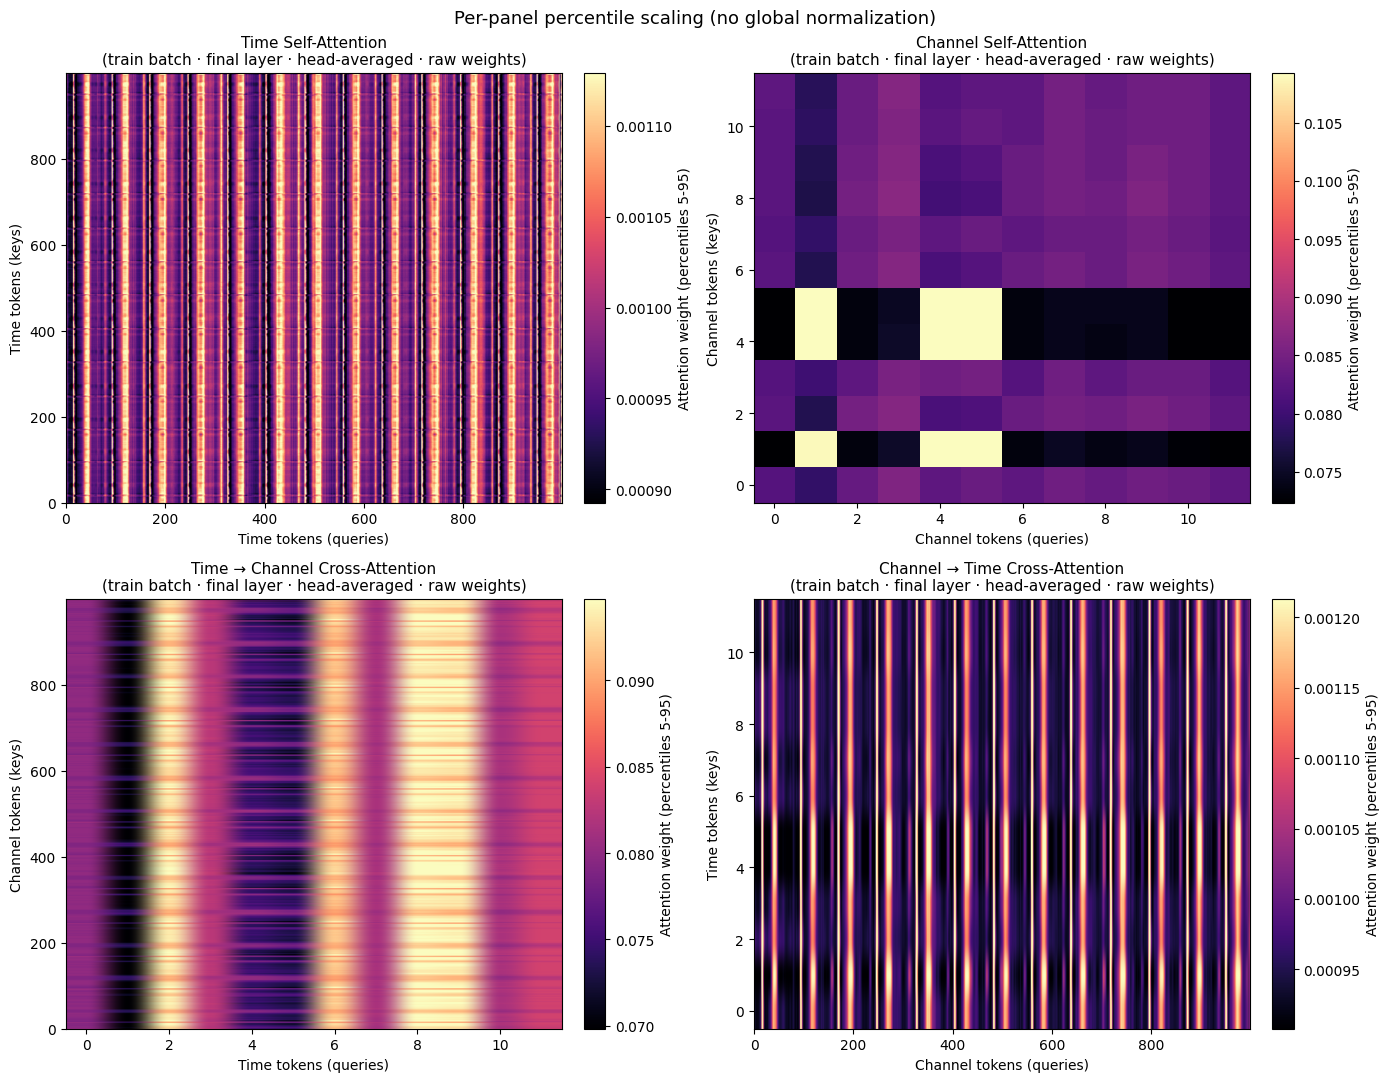

In [20]:
if 'current_attention_maps' not in globals() or 'current_attention_scales' not in globals():
    raise RuntimeError('Run the capture cell first to populate current_attention_maps/scales.')

plot_specs = [
    (
        'time_self',
        'Time Self-Attention',
        'Time tokens (queries)',
        'Time tokens (keys)',
    ),
    (
        'channel_self',
        'Channel Self-Attention',
        'Channel tokens (queries)',
        'Channel tokens (keys)',
    ),
    (
        'time_to_channel',
        'Time → Channel Cross-Attention',
        'Time tokens (queries)',
        'Channel tokens (keys)',
    ),
    (
        'channel_to_time',
        'Channel → Time Cross-Attention',
        'Channel tokens (queries)',
        'Time tokens (keys)',
    ),
]

fig, axes = plt.subplots(2, 2, figsize=(14, 11))
for ax, (key, title, xlabel, ylabel) in zip(axes.ravel(), plot_specs):
    matrix = current_attention_maps.get(key)
    scale = current_attention_scales.get(key)
    if matrix is None or scale is None:
        ax.axis('off')
        ax.set_title(f'{title} (not captured)')
        continue
    vmin, vmax = scale
    image = plot_attention_matrix(
        ax,
        matrix,
        f"{title}\n(train batch · final layer · head-averaged · raw weights)",
        xlabel,
        ylabel,
        vmin,
        vmax,
    )
    fig.colorbar(
        image,
        ax=ax,
        fraction=0.046,
        pad=0.04,
        label=f'Attention weight (percentiles {ATTN_PERCENTILES[0]}-{ATTN_PERCENTILES[1]})',
    )

fig.suptitle(
    "Per-panel percentile scaling (no global normalization)",
    fontsize=13,
)
plt.tight_layout()
plt.show()